In [15]:
import os
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import time

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model, Sequential
from keras.layers import Flatten, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, BatchNormalization, MaxPooling2D, SeparableConv2D, Add, Concatenate

from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam

from keras.applications.mobilenet import MobileNet
from keras.applications.efficientnet import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from keras import layers, regularizers

import matplotlib.pyplot as plt

from PIL import Image
from datetime import datetime

from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard

import pickle
from keras import backend as K

import seaborn as sns

# NOTE

Panduan Istilah:

buat
1) autosave nama based on akurasi terbaik
2) buat plot history
3) buat confusion matrik

RAM usage
1) ketika train LightCNN tidak bisa bareng MobileNet

Train
1) mobileNet 0.0001 32 batch
2) LightCNN 0.0001 64 batch

Perbandingan Tesla T4 vs A100 SXM
per epoch 162s vs 44s

In [15]:
!nvidia-smi -q



==============NVSMI LOG==============

Timestamp                                 : Sun Nov 19 16:42:50 2023
Driver Version                            : 470.161.03
CUDA Version                              : 11.4

Attached GPUs                             : 1
GPU 00000000:B7:00.0
    Product Name                          : NVIDIA A100-SXM4-40GB
    Product Brand                         : NVIDIA
    Display Mode                          : Enabled
    Display Active                        : Disabled
    Persistence Mode                      : Enabled
    MIG Mode
        Current                           : Disabled
        Pending                           : Disabled
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : 1322820085091
    GPU UUID                              : GPU-94403

# EDA - FusionFER

In [ ]:
df = pd.read_csv('icml-CKplus-FERext.csv')
df.head()

Unnamed: 0  emotion     Usage  \
0           0        5  Training   
1           1        5  Training   
2           2        5  Training   
3           3        5  Training   
4           4        5  Training   

                                              pixels  
0  247 247 213 212 173 125 87 79 72 71 82 111 144...  
1  33 29 28 34 39 42 42 34 36 45 42 54 56 55 63 6...  
2  226 229 226 228 222 223 224 222 222 223 230 23...  
3  58 80 94 115 159 224 233 231 234 238 231 224 2...  
4  85 80 86 86 82 73 68 57 66 77 68 73 71 79 76 8...

In [ ]:
print(df['emotion'].value_counts())
print(df['emotion'].value_counts().sum())

# Functions

In [16]:
def string_to_image(string):
    pixels = np.array([int(pixel) for pixel in string.split(' ')], dtype=np.uint8)
    return pixels.reshape(48, 48, 1)

def select_feature(df, column_name):
  class_name = df['Usage']
  train = df[class_name == 'Training']
  val = df[class_name == 'PublicTest']
  test = df[class_name == 'PrivateTest']

  x_train = np.stack(train[column_name].values)
  x_val = np.stack(val[column_name].values)
  x_test = np.stack(test[column_name].values)

  y_train = to_categorical(train['emotion'], num_classes=7)
  y_val = to_categorical(val['emotion'], num_classes=7)
  y_test = to_categorical(test['emotion'], num_classes=7)

  # Menghitung jumlah data untuk setiap label
  train_counts = y_train.sum()
  val_counts = y_val.sum()
  test_counts = y_test.sum()

  print("jumlah data train : ")
  print(train_counts)
  print("jumlah data validation : ")
  print(val_counts)
  print("jumlah data test : ")
  print(test_counts)

  return x_train, x_val, x_test, y_train, y_val, y_test

class BestModelCallback(Callback):
    def __init__(self, monitor='accuracy'):
        super(BestModelCallback, self).__init__()
        self.monitor = monitor    # metric was monitored
        self.best = 0             # best value was monitored
        self.best_epoch = 0
        self.best_time = 0

    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        
        current = logs.get(self.monitor)
        if current > self.best:
            self.best = current
            self.best_epoch = epoch + 1
            self.best_time = time.time() - self.start_time

        # elapsed_time = time.time() - self.start_time
        # print(f'Epoch {epoch + 1}: Training time - {elapsed_time:.2f} s')
        
    def on_train_end(self, logs=None):
        full_time = time.time() - self.start_time
        print(f'\n|===========General==============|')
        print(f'  Training Process --> {full_time/60:0.2f} menit')
        
        print(f'\n|=========Best Model============|')
        print(f'Monitor : {self.monitor}')
        print(f"Epoch : {self.best_epoch}")
        print(f"{self.monitor} : {self.best*100:.2f} %")
        print(f"Time : {self.best_time/60:0.2f} menit")


In [17]:
def display_evaluation(history):
    plt.plot(history['accuracy'], label='Training Acc')
    plt.plot(history['val_accuracy'], label='Validation Acc')
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    plt.show()

    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    plt.show()

# display_evaluation(hist)


In [18]:
def display_evaluation_v2(history, save_path=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Plot Accuracy
    axes[0].plot(history['accuracy'], label='Training Acc')
    axes[0].plot(history['val_accuracy'], label='Validation Acc')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend(loc='best')

    # Plot Loss
    axes[1].plot(history['loss'], label='Training Loss')
    axes[1].plot(history['val_loss'], label='Validation Loss')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend(loc='best')

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(save_path)
        
    plt.show()

In [19]:
def show_report(y_true, y_pred, digits=2):

    # display confusion matrix
    confusion_mtx = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:')
    print(confusion_mtx)
    print()

    # classification report
    class_names = ['Angry','Disgust','Fear','Happy','Sad', 'Surprise', 'Neutral']  
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=class_names, digits=digits))

In [20]:
def get_predict(model, x_test, y_test):
    pred = model.predict(x_test)
    y_pred = np.argmax(pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    evaluate = model.evaluate(x_test, y_test)
    print(f'test loss : {evaluate[0]}')
    print(f'test acc  : {evaluate[1]}')
    
    return y_pred, y_true

In [21]:
def display_confusion_mtx(y_true, y_pred, save=False, name_file="confusion_matrik"):
    CLASS = ['Angry','Disgust','Fear','Happy','Sad', 'Surprise', 'Neutral'] 
    
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred) * 100
    
    sns.set(font_scale=.8)
    sns.heatmap(cm/np.sum(cm, axis=1), annot=True, xticklabels=CLASS, yticklabels=CLASS, fmt='.2f')
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.title(f'Confusion Matrix\n Accuracy {acc:0.2f} %')
    plt.xlabel("Predicted") 
    plt.ylabel("Actual") 
    
    if save:
        plt.savefig(f'{name_file}.png', bbox_inches = 'tight', dpi=240)
    
    plt.show()

# EfficientNet - FusionFER

Input (48,48,3) - rgb_48


Batch  128, 64, 32, 8

Lr     0.1, 0.01, 0.001, 0.0001, 0.0005


Freezed :

| lr | Val Acc | Acc| Augmented | Best Time | Epoch | Note |
|--- |---|---|---|---|---|---|
|0.01| 39.70 | 42.55 | Yes | 48.96m | 88 | Barebone  |
|0.01| 24.94 | 17.02 | Yes | 0.67m | 1 | BN |
|0.0001| 53.97 | 59.15 | Yes | 51.40m | 92 | FCL1024 |
|0.0001| 87.76 | 98.11 | Yes | 47.73m | 84 | BN FCL1024 |

Variasi EfficientNet :
| lr | Val Acc | Acc| Augmented | Best Time | Epoch | Note |
|--- |---|---|---|---|---|---|
|0.0001| 91.00 | 98.81 | Yes | 127.61m | 223 | B0  |
|0.0001| 90.64 | 97.97 | Yes | 72.27m | 93 | B1 |
|0.0001| 90.63 | 98.47 | Yes | 91.20m | 114 | B2 |
|0.0001| 90.81 | 98.17 | Yes | 93.12m | 102 | B3 |
|0.0001| 91.08 | 98.47 | Yes | 121.01m | 108 | B4 |
|0.0001| **91.45** | 97.90 | Yes | 105.07m | 77 | **B5** |
|0.0001| 91.42 | 98.62 | Yes | 194.99m | 122 | B6 |
|0.0001| 90.97 | 98.29 | Yes | 135.97m | 85 | B7 |

Variasi EfficientNetB0 :
| lr | Val Acc | Acc| Augmented | Best Time | Epoch | Note |
|--- |---|---|---|---|---|---|
|0.1| 67.32 | 71.04 | Yes | 143.49m | 251 | B0  |
|0.01| 75.90 | 83.90 | Yes | 70.15m | 126 | B0  |
|0.001| 89.05 | 97.82  | Yes | 139.71m | 245 | B0  |
|0.0005| 89.91 | 98.18  | Yes | 126.36m | 220 | B0  |
|0.0001| **91.00** | 98.81  | Yes | 127.61m | 223 | B0  |

Variasi EfficientNetB0 224 :
| lr | Val Acc | Acc| Augmented | Best Time | Epoch | Note |
|--- |---|---|---|---|---|---|
|0.01| **89.24** | 95.39  | Yes | 252.43m | 31 | B0  |
|0.001| 87.46 | 94.78  | Yes | 210.26m | 23 | B0  |
|0.0001| 88.30 | 95.83   | Yes | 213.05m | 26 | B0  |

Paper Utami P:
| lr | Val Acc | Acc| Augmented | Best Time | Epoch | Note |
|--- |---|---|---|---|---|---|
| - | 89.73 | -  | Yes | 37.16m | - | B0  |
| - | 94.44 | -  | Yes | 67.83m | - | B3  |

Batch Experiment:

Model          : **EfficietNetB0**

Learning rate  : _0.0001_

Augmented : Yes

| Batch | Val Acc | Best Time | Epoch | per epoch |
|---|---|---|---|---|
| 8 | 80.16 | 246.51m | 64 | 228s |
| 16 | 89.22 | 249.09m | 127 | 117s |
| 32 | **90.08** | 117.35m | 114 | 60s |
| 64 | 89.69 | 73.08m | 126 | 35s |
| 128 | 89.13 | 65.97m |118 | 33ss |

Tipe EfficientNet :
| Tipe | Time | Parameter | Per Epoch |
|--- |---|---|---|
| B0 | 127.61m | 4,058,538  | 35s |
| B1 | 72.27m  | 6,584,206  | 47s |
| B2 | 91.20m  | 7,778,432  | 48s |
| B3 | 93.12m  | 10,794,294 | 55s |
| B4 | 121.01m | 17,686,374 | 67s |
| B5 | 105.07m | 28,527,870 | 81s |
| B6 | 194.99m | 40,976,278 | 95s |
| B7 | 135.97m | 64,115,614 | 95s |

## Load Data

In [22]:
with open('pkl/rgb_48.pkl', 'rb') as f:
    df = pickle.load(f) # load pkl data
df.head()

Unnamed: 0  emotion     Usage  \
0           0        5  Training   
1           1        5  Training   
2           2        5  Training   
3           3        5  Training   
4           4        5  Training   

                                              pixels  \
0  247 247 213 212 173 125 87 79 72 71 82 111 144...   
1  33 29 28 34 39 42 42 34 36 45 42 54 56 55 63 6...   
2  226 229 226 228 222 223 224 222 222 223 230 23...   
3  58 80 94 115 159 224 233 231 234 238 231 224 2...   
4  85 80 86 86 82 73 68 57 66 77 68 73 71 79 76 8...   

                                              rgb_48  
0  [[[247, 247, 247], [247, 247, 247], [213, 213,...  
1  [[[33, 33, 33], [29, 29, 29], [28, 28, 28], [3...  
2  [[[226, 226, 226], [229, 229, 229], [226, 226,...  
3  [[[58, 58, 58], [80, 80, 80], [94, 94, 94], [1...  
4  [[[85, 85, 85], [80, 80, 80], [86, 86, 86], [8...

## Preprocessing

In [23]:
# extract Feature
x_train, x_val, x_test, y_train, y_val, y_test = select_feature(df, 'rgb_48')

jumlah data train : 
60184.0
jumlah data validation : 
3589.0
jumlah data test : 
3589.0


In [24]:
# image Augmentation
datagen = ImageDataGenerator(
    rotation_range = 20,
    shear_range = 0.3,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [25]:
# set training parameter
batch_size = 64
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = (x_val, y_val)

## Model EfficientNetB0

In [11]:
!nvidia-smi

Sat Nov 25 14:02:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:90:00.0 Off |                    0 |
| N/A   34C    P0    56W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [58]:
def build_model_efficient(lr=0.001):
    #model EfficientNetB0
    efficient = EfficientNetB0(weights='imagenet', 
                               include_top=False, 
                               input_shape=(48, 48, 3))
    efficient.trainable = True

    x = efficient.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(7, activation='softmax')(x)

    efficient = Model(inputs=efficient.input, 
                      outputs=output, 
                      name="EfficientNetB0")
    
    efficient.compile(optimizer=Adam(learning_rate=lr), 
                      loss='categorical_crossentropy', metrics=['accuracy'])

    efficient.summary()
    return efficient

### Lr 0.1

In [60]:
build_model_efficient()

Model: "EfficientNetB0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling_9 (Rescaling)        (None, 48, 48, 3)    0           ['input_10[0][0]']               
                                                                                                  
 normalization_9 (Normalization  (None, 48, 48, 3)   7           ['rescaling_9[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.truediv_11 (TFOpLambda  (None, 48, 48, 3)   0           ['normalization_9[0]

In [38]:
efficient = build_model_efficient(lr=0.1)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

model name    :  EfficientNetB0
learning rate :  0.1


In [39]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB0_lr1' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [40]:
epochs = 256
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])


Epoch 1/256
940/941 [============================>.] - ETA: 0s - loss: 2.2905 - accuracy: 0.2183
Epoch 1: val_accuracy improved from -inf to 0.24965, saving model to models/EfficientNetB0_lr1_20231203-094501.h5
941/941 [==============================] - 43s 38ms/step - loss: 2.2899 - accuracy: 0.2183 - val_loss: 8.1578 - val_accuracy: 0.2497
Epoch 2/256
940/941 [============================>.] - ETA: 0s - loss: 1.7899 - accuracy: 0.2813
Epoch 2: val_accuracy did not improve from 0.24965
941/941 [==============================] - 35s 37ms/step - loss: 1.7896 - accuracy: 0.2814 - val_loss: 4.1807 - val_accuracy: 0.0911
Epoch 3/256
940/941 [============================>.] - ETA: 0s - loss: 1.7355 - accuracy: 0.3174
Epoch 3: val_accuracy did not improve from 0.24965
941/941 [==============================] - 34s 37ms/step - loss: 1.7352 - accuracy: 0.3176 - val_loss: 13.5863 - val_accuracy: 0.0407
Epoch 4/256
940/941 [============================>.] - ETA: 0s - loss: 1.6241 - accuracy: 0.3

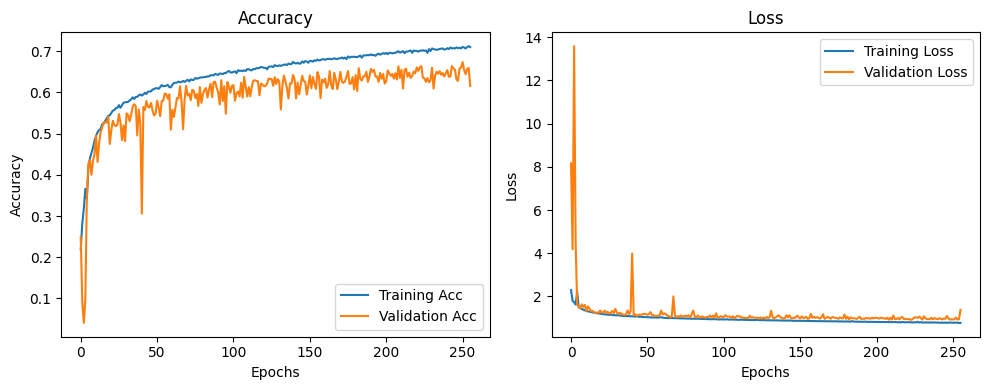

In [42]:
sns.reset_defaults()
plot_name = str(model_name)
display_evaluation_v2(hist.history, 'plot/' + plot_name)

In [13]:
model_name = 'EfficientNetB0_lr1_20231203-094501'
efficient = load_model(f'models/{model_name}.h5')

113/113 [==============================] - 2s 9ms/step - loss: 0.9082 - accuracy: 0.6712
test loss : 0.9082168936729431
test acc  : 0.6712176203727722
Confusion Matrix:
[[287   5  50  19  45   7  78]
 [ 14  28   2   3   4   3   1]
 [ 66   0 239  19  87  50  67]
 [ 22   1  15 767  17  16  41]
 [ 59   2  62  28 287  11 145]
 [  6   0  33  26   7 324  20]
 [ 22   0  29  31  54  13 477]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.60      0.58      0.59       491
     Disgust       0.78      0.51      0.62        55
        Fear       0.56      0.45      0.50       528
       Happy       0.86      0.87      0.87       879
         Sad       0.57      0.48      0.52       594
    Surprise       0.76      0.78      0.77       416
     Neutral       0.58      0.76      0.66       626

    accuracy                           0.67      3589
   macro avg       0.67      0.63      0.65      3589
weighted avg       0.67      0.67      0.67    

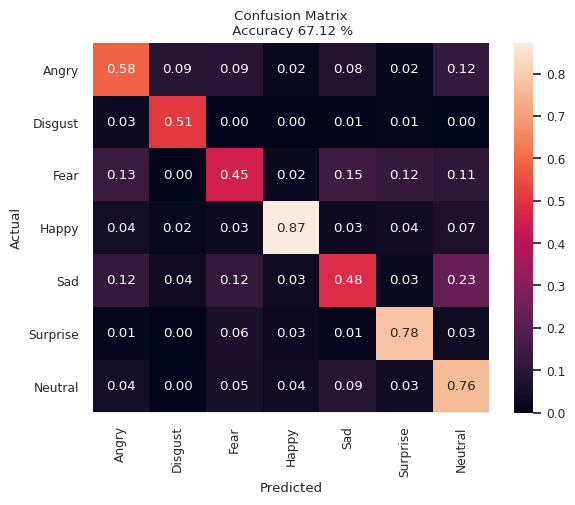

In [15]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred, save=True, name_file=f'plot/conf_{model_name}')

In [14]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred, digits=4)

2023-12-04 02:46:16.182090: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


 21/113 [====>.........................] - ETA: 0s

2023-12-04 02:46:17.540469: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


113/113 [==============================] - 2s 9ms/step - loss: 0.9082 - accuracy: 0.6712
test loss : 0.9082168936729431
test acc  : 0.6712176203727722
Confusion Matrix:
[[287   5  50  19  45   7  78]
 [ 14  28   2   3   4   3   1]
 [ 66   0 239  19  87  50  67]
 [ 22   1  15 767  17  16  41]
 [ 59   2  62  28 287  11 145]
 [  6   0  33  26   7 324  20]
 [ 22   0  29  31  54  13 477]]

Classification Report:
              precision    recall  f1-score   support

       Angry     0.6029    0.5845    0.5936       491
     Disgust     0.7778    0.5091    0.6154        55
        Fear     0.5558    0.4527    0.4990       528
       Happy     0.8589    0.8726    0.8657       879
         Sad     0.5729    0.4832    0.5242       594
    Surprise     0.7642    0.7788    0.7714       416
     Neutral     0.5754    0.7620    0.6557       626

    accuracy                         0.6712      3589
   macro avg     0.6725    0.6347    0.6464      3589
weighted avg     0.6703    0.6712    0.6666    

In [16]:
y_pred, y_true = get_predict(efficient, x_val, y_val)

show_report(y_true, y_pred)

113/113 [==============================] - 1s 9ms/step - loss: 0.9296 - accuracy: 0.6732
test loss : 0.9296396970748901
test acc  : 0.6731680035591125
Confusion Matrix:
[[270   5  32  27  40  12  81]
 [  9  30   6   0   4   0   7]
 [ 31   3 238  22  93  33  76]
 [ 18   0   9 780  10  11  67]
 [ 64   1  72  29 326   9 152]
 [ 13   0  31  18   4 329  20]
 [ 30   0  22  47  54  11 443]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.62      0.58      0.60       467
     Disgust       0.77      0.54      0.63        56
        Fear       0.58      0.48      0.53       496
       Happy       0.85      0.87      0.86       895
         Sad       0.61      0.50      0.55       653
    Surprise       0.81      0.79      0.80       415
     Neutral       0.52      0.73      0.61       607

    accuracy                           0.67      3589
   macro avg       0.68      0.64      0.65      3589
weighted avg       0.68      0.67      0.67    

### Lr 0.01

In [9]:
#model

efficient = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
efficient.trainable = True

x = efficient.output
x = GlobalAveragePooling2D()(x)
output = Dense(7, activation='softmax')(x)

efficient = Model(inputs=efficient.input, outputs=output)
efficient.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

efficient.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 48, 48, 3)    0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 48, 48, 3)   7           ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 48, 48, 3)   0           ['normalization_1[0][0]']  

In [10]:
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientBO' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}/' + executed_time
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [14]:
#last epoch 64

epochs = 16
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/16
940/941 [============================>.] - ETA: 0s - loss: 0.6896 - accuracy: 0.7444
Epoch 1: val_accuracy improved from 0.67930 to 0.68515, saving model to models/EfficientBO_20231118-162407.h5
941/941 [==============================] - 34s 36ms/step - loss: 0.6897 - accuracy: 0.7444 - val_loss: 0.8902 - val_accuracy: 0.6851
Epoch 2/16
941/941 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.7476
Epoch 2: val_accuracy did not improve from 0.68515
941/941 [==============================] - 33s 35ms/step - loss: 0.6822 - accuracy: 0.7476 - val_loss: 0.9084 - val_accuracy: 0.6626
Epoch 3/16
941/941 [==============================] - ETA: 0s - loss: 0.6819 - accuracy: 0.7488
Epoch 3: val_accuracy did not improve from 0.68515
941/941 [==============================] - 33s 35ms/step - loss: 0.6819 - accuracy: 0.7488 - val_loss: 0.9119 - val_accuracy: 0.6704
Epoch 4/16
941/941 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.7501
Epoch

In [16]:
#last epoch 0

epochs = 128
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/128


2023-11-27 05:43:17.744464: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-11-27 05:43:19.113223: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


941/941 [==============================] - ETA: 0s - loss: 1.5536 - accuracy: 0.4005
Epoch 1: val_accuracy improved from -inf to 0.45277, saving model to models/EfficientBO_20231127-054242.h5
941/941 [==============================] - 45s 39ms/step - loss: 1.5536 - accuracy: 0.4005 - val_loss: 1.5539 - val_accuracy: 0.4528
Epoch 2/128
941/941 [==============================] - ETA: 0s - loss: 1.3397 - accuracy: 0.4890
Epoch 2: val_accuracy improved from 0.45277 to 0.47841, saving model to models/EfficientBO_20231127-054242.h5
941/941 [==============================] - 34s 36ms/step - loss: 1.3397 - accuracy: 0.4890 - val_loss: 1.4973 - val_accuracy: 0.4784
Epoch 3/128
941/941 [==============================] - ETA: 0s - loss: 1.2339 - accuracy: 0.5315
Epoch 3: val_accuracy did not improve from 0.47841
941/941 [==============================] - 33s 35ms/step - loss: 1.2339 - accuracy: 0.5315 - val_loss: 1.4797 - val_accuracy: 0.4544
Epoch 4/128
941/941 [==============================] -

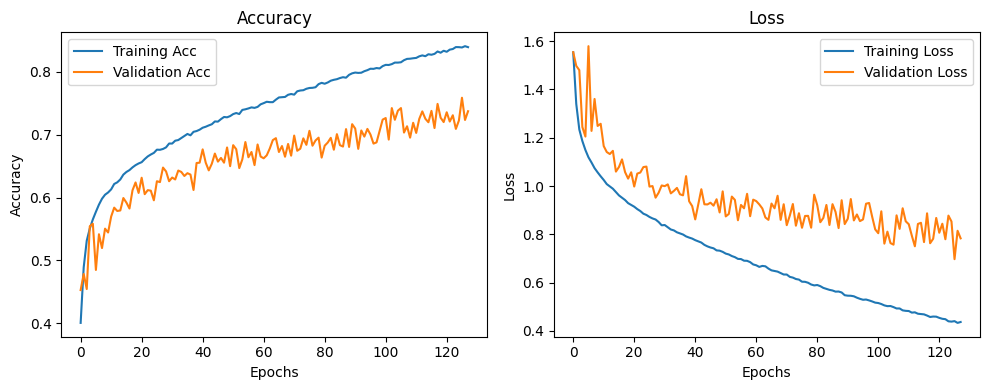

In [21]:
sns.reset_defaults()
model_name = 'EfficientBO_20231127-054242'
plot = pd.read_csv(f'history_csv/{model_name}.csv')
display_evaluation_v2(plot, 'plot/' + model_name)

In [ ]:
sns.reset_defaults()
model_name = 'EfficientBO_20231127-054242'
plot = pd.read_csv(f'history_csv/{model_name}.csv')
display_evaluation_v2(plot, 'plot/' + model_name)

In [15]:
model_name = 'EfficientBO_20231127-054242'
efficient = load_model(f'models/{model_name}.h5')

113/113 [==============================] - 2s 9ms/step - loss: 0.6573 - accuracy: 0.7718
test loss : 0.6572555899620056
test acc  : 0.7718027234077454
Confusion Matrix:
[[397   3  21   7  37   4  22]
 [ 10  44   0   0   0   0   1]
 [ 76   3 333   7  59  14  36]
 [ 34   2  10 785  16   8  24]
 [ 61   0  45  11 390   3  84]
 [ 22   0  21   8   9 344  12]
 [ 42   0  22  20  59   6 477]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.62      0.81      0.70       491
     Disgust       0.85      0.80      0.82        55
        Fear       0.74      0.63      0.68       528
       Happy       0.94      0.89      0.91       879
         Sad       0.68      0.66      0.67       594
    Surprise       0.91      0.83      0.87       416
     Neutral       0.73      0.76      0.74       626

    accuracy                           0.77      3589
   macro avg       0.78      0.77      0.77      3589
weighted avg       0.78      0.77      0.77    

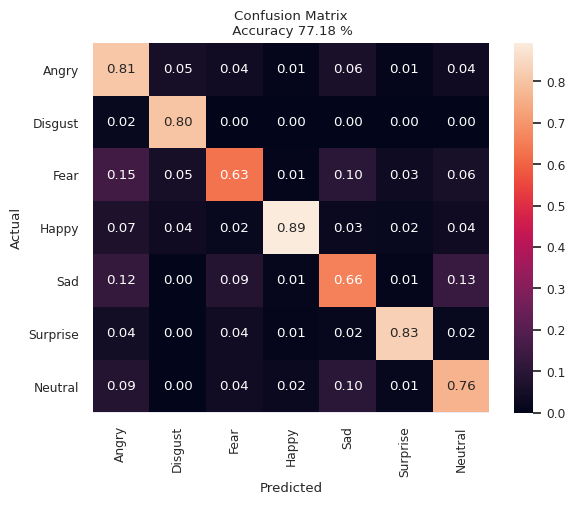

In [20]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred, save=True, name_file=f'plot/conf_{model_name}')

In [16]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred, digits=4)

113/113 [==============================] - 2s 9ms/step - loss: 0.6573 - accuracy: 0.7718
test loss : 0.6572555899620056
test acc  : 0.7718027234077454
Confusion Matrix:
[[397   3  21   7  37   4  22]
 [ 10  44   0   0   0   0   1]
 [ 76   3 333   7  59  14  36]
 [ 34   2  10 785  16   8  24]
 [ 61   0  45  11 390   3  84]
 [ 22   0  21   8   9 344  12]
 [ 42   0  22  20  59   6 477]]

Classification Report:
              precision    recall  f1-score   support

       Angry     0.6184    0.8086    0.7008       491
     Disgust     0.8462    0.8000    0.8224        55
        Fear     0.7367    0.6307    0.6796       528
       Happy     0.9368    0.8931    0.9144       879
         Sad     0.6842    0.6566    0.6701       594
    Surprise     0.9077    0.8269    0.8654       416
     Neutral     0.7271    0.7620    0.7441       626

    accuracy                         0.7718      3589
   macro avg     0.7796    0.7683    0.7710      3589
weighted avg     0.7806    0.7718    0.7734    

In [19]:
y_pred, y_true = get_predict(efficient, x_val, y_val)

show_report(y_true, y_pred)

113/113 [==============================] - 1s 9ms/step - loss: 0.6972 - accuracy: 0.7590
test loss : 0.6971953511238098
test acc  : 0.7589858174324036
Confusion Matrix:
[[360   0  20   6  44   6  31]
 [  7  44   1   0   0   2   2]
 [ 52   2 311   5  61  19  46]
 [ 33   1  11 779  18   5  48]
 [ 94   2  33  16 433   8  67]
 [ 18   0  30  11  10 340   6]
 [ 47   2  14  24  59   4 457]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.59      0.77      0.67       467
     Disgust       0.86      0.79      0.82        56
        Fear       0.74      0.63      0.68       496
       Happy       0.93      0.87      0.90       895
         Sad       0.69      0.66      0.68       653
    Surprise       0.89      0.82      0.85       415
     Neutral       0.70      0.75      0.72       607

    accuracy                           0.76      3589
   macro avg       0.77      0.76      0.76      3589
weighted avg       0.77      0.76      0.76    

### Lr 0.001

In [33]:
efficient = build_model_efficient(lr=0.001)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

model name    :  EfficientNetB0
learning rate :  0.001


In [34]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB0_lr001' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [35]:
#plan epoch 

epochs = 256
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/256
940/941 [============================>.] - ETA: 0s - loss: 1.3288 - accuracy: 0.4939
Epoch 1: val_accuracy improved from -inf to 0.54277, saving model to models/EfficientNetB0_lr001_20231119-172240.h5
941/941 [==============================] - 43s 39ms/step - loss: 1.3284 - accuracy: 0.4941 - val_loss: 1.1934 - val_accuracy: 0.5428
Epoch 2/256
940/941 [============================>.] - ETA: 0s - loss: 1.0930 - accuracy: 0.5887
Epoch 2: val_accuracy improved from 0.54277 to 0.57481, saving model to models/EfficientNetB0_lr001_20231119-172240.h5
941/941 [==============================] - 35s 37ms/step - loss: 1.0929 - accuracy: 0.5887 - val_loss: 1.1355 - val_accuracy: 0.5748
Epoch 3/256
941/941 [==============================] - ETA: 0s - loss: 1.0141 - accuracy: 0.6176
Epoch 3: val_accuracy improved from 0.57481 to 0.57927, saving model to models/EfficientNetB0_lr001_20231119-172240.h5
941/941 [==============================] - 35s 37ms/step - loss: 1.0141 - accuracy: 0.617

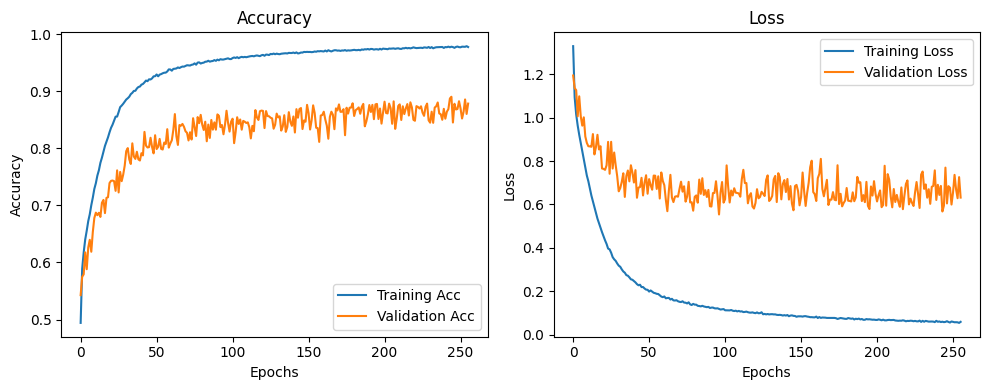

In [45]:
sns.reset_defaults()
model_name = 'EfficientNetB0_lr001_20231119-172240'
plot = pd.read_csv(f'history_csv/{model_name}.csv')
display_evaluation_v2(plot, 'plot/' + model_name)

In [35]:
model_name = 'EfficientNetB0_lr001_20231119-172240'
efficient = load_model(f'models/{model_name}.h5')

113/113 [==============================] - 2s 9ms/step - loss: 0.5017 - accuracy: 0.9044
test loss : 0.5016730427742004
test acc  : 0.9044302105903625
Confusion Matrix:
[[440   1  12   4  21   4   9]
 [  5  49   0   0   1   0   0]
 [ 29   1 457   4  24   4   9]
 [ 13   0   7 835   7   4  13]
 [ 24   0  15   7 525   1  22]
 [  7   0  22   7   2 377   1]
 [ 11   3  13  10  24   2 563]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.83      0.90      0.86       491
     Disgust       0.91      0.89      0.90        55
        Fear       0.87      0.87      0.87       528
       Happy       0.96      0.95      0.96       879
         Sad       0.87      0.88      0.88       594
    Surprise       0.96      0.91      0.93       416
     Neutral       0.91      0.90      0.91       626

    accuracy                           0.90      3589
   macro avg       0.90      0.90      0.90      3589
weighted avg       0.91      0.90      0.90    

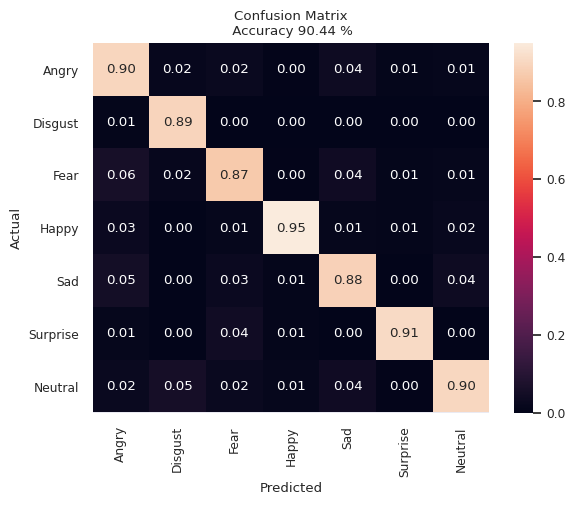

In [36]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred, save=True, name_file=f'plot/conf_{model_name}')

In [ ]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred, digits=4)

113/113 [==============================] - 1s 8ms/step - loss: 0.5017 - accuracy: 0.9044
test loss : 0.5016730427742004
test acc  : 0.9044302105903625
Confusion Matrix:
[[440   1  12   4  21   4   9]
 [  5  49   0   0   1   0   0]
 [ 29   1 457   4  24   4   9]
 [ 13   0   7 835   7   4  13]
 [ 24   0  15   7 525   1  22]
 [  7   0  22   7   2 377   1]
 [ 11   3  13  10  24   2 563]]

Classification Report:
              precision    recall  f1-score   support

       Angry     0.8318    0.8961    0.8627       491
     Disgust     0.9074    0.8909    0.8991        55
        Fear     0.8688    0.8655    0.8672       528
       Happy     0.9631    0.9499    0.9565       879
         Sad     0.8692    0.8838    0.8765       594
    Surprise     0.9617    0.9062    0.9332       416
     Neutral     0.9125    0.8994    0.9059       626

    accuracy                         0.9044      3589
   macro avg     0.9021    0.8989    0.9001      3589
weighted avg     0.9059    0.9044    0.9049    

In [62]:
y_pred, y_true = get_predict(efficient, x_val, y_val)

show_report(y_true, y_pred, digits=2)

113/113 [==============================] - 1s 9ms/step - loss: 0.5946 - accuracy: 0.8905
test loss : 0.5945627093315125
test acc  : 0.8904987573623657
Confusion Matrix:
[[408   1  17   5  20   4  12]
 [  1  51   1   0   2   0   1]
 [ 22   1 410   6  37   5  15]
 [ 12   0   9 855   8   3   8]
 [ 31   0  19  12 566   1  24]
 [  7   0  22   7   1 375   3]
 [ 15   1   7  18  35   0 531]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.82      0.87      0.85       467
     Disgust       0.94      0.91      0.93        56
        Fear       0.85      0.83      0.84       496
       Happy       0.95      0.96      0.95       895
         Sad       0.85      0.87      0.86       653
    Surprise       0.97      0.90      0.93       415
     Neutral       0.89      0.87      0.88       607

    accuracy                           0.89      3589
   macro avg       0.90      0.89      0.89      3589
weighted avg       0.89      0.89      0.89    

### Lr 0.0005

In [40]:
efficient = build_model_efficient(lr=0.0005)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

model name    :  EfficientNetB0
learning rate :  0.0005


In [41]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB0_lr0005' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [42]:
#plan epoch 

epochs = 256
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/256
941/941 [==============================] - ETA: 0s - loss: 1.3946 - accuracy: 0.4675
Epoch 1: val_accuracy improved from -inf to 0.53803, saving model to models/EfficientNetB0_lr0005_20231119-225644.h5
941/941 [==============================] - 42s 38ms/step - loss: 1.3946 - accuracy: 0.4675 - val_loss: 1.2528 - val_accuracy: 0.5380
Epoch 2/256
940/941 [============================>.] - ETA: 0s - loss: 1.1122 - accuracy: 0.5794
Epoch 2: val_accuracy improved from 0.53803 to 0.55614, saving model to models/EfficientNetB0_lr0005_20231119-225644.h5
941/941 [==============================] - 34s 36ms/step - loss: 1.1120 - accuracy: 0.5796 - val_loss: 1.1698 - val_accuracy: 0.5561
Epoch 3/256
940/941 [============================>.] - ETA: 0s - loss: 1.0202 - accuracy: 0.6154
Epoch 3: val_accuracy improved from 0.55614 to 0.61354, saving model to models/EfficientNetB0_lr0005_20231119-225644.h5
941/941 [==============================] - 34s 36ms/step - loss: 1.0201 - accuracy: 0.

report

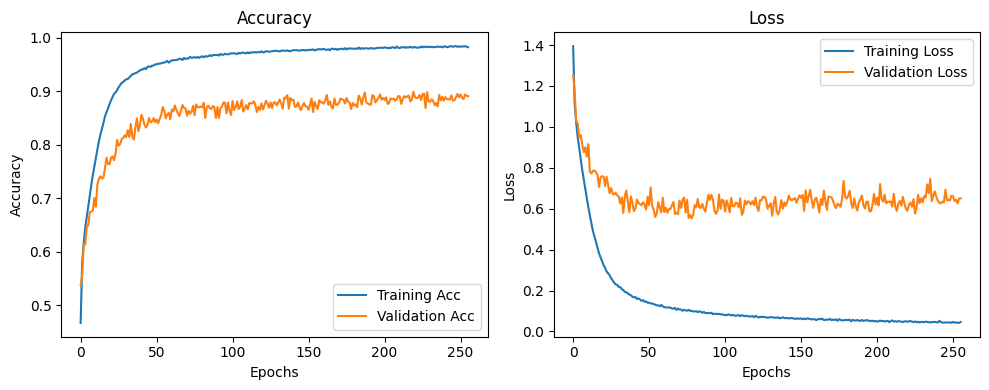

In [21]:
sns.reset_defaults()
model_name = 'EfficientNetB0_lr0005_20231119-225644'
plot = pd.read_csv(f'history_csv/{model_name}.csv')
display_evaluation_v2(plot, 'plot/' + model_name)

In [19]:
model_name = 'EfficientNetB0_lr0005_20231119-225644'
efficient = load_model(f'models/{model_name}.h5')

113/113 [==============================] - 2s 9ms/step - loss: 0.5579 - accuracy: 0.9050
test loss : 0.557883083820343
test acc  : 0.9049874544143677
Confusion Matrix:
[[435   3  16   4  20   5   8]
 [  1  52   1   0   1   0   0]
 [ 21   3 451   2  30  13   8]
 [ 10   0   6 840   4  12   7]
 [ 13   0  23  14 516   3  25]
 [  4   0  13   4   3 390   2]
 [ 17   2   8  11  18   6 564]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.87      0.89      0.88       491
     Disgust       0.87      0.95      0.90        55
        Fear       0.87      0.85      0.86       528
       Happy       0.96      0.96      0.96       879
         Sad       0.87      0.87      0.87       594
    Surprise       0.91      0.94      0.92       416
     Neutral       0.92      0.90      0.91       626

    accuracy                           0.90      3589
   macro avg       0.89      0.91      0.90      3589
weighted avg       0.91      0.90      0.90     

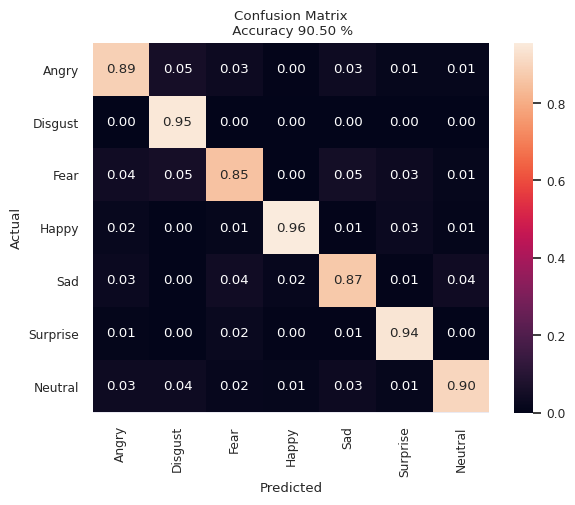

In [23]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred, save=True, name_file=f'plot/conf_{model_name}')

In [20]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred, digits=4)

113/113 [==============================] - 2s 9ms/step - loss: 0.5579 - accuracy: 0.9050
test loss : 0.557883083820343
test acc  : 0.9049874544143677
Confusion Matrix:
[[435   3  16   4  20   5   8]
 [  1  52   1   0   1   0   0]
 [ 21   3 451   2  30  13   8]
 [ 10   0   6 840   4  12   7]
 [ 13   0  23  14 516   3  25]
 [  4   0  13   4   3 390   2]
 [ 17   2   8  11  18   6 564]]

Classification Report:
              precision    recall  f1-score   support

       Angry     0.8683    0.8859    0.8770       491
     Disgust     0.8667    0.9455    0.9043        55
        Fear     0.8707    0.8542    0.8623       528
       Happy     0.9600    0.9556    0.9578       879
         Sad     0.8716    0.8687    0.8702       594
    Surprise     0.9091    0.9375    0.9231       416
     Neutral     0.9186    0.9010    0.9097       626

    accuracy                         0.9050      3589
   macro avg     0.8950    0.9069    0.9006      3589
weighted avg     0.9051    0.9050    0.9050     

In [24]:
y_pred, y_true = get_predict(efficient, x_val, y_val)

show_report(y_true, y_pred)

113/113 [==============================] - 1s 9ms/step - loss: 0.5997 - accuracy: 0.8991
test loss : 0.5996989011764526
test acc  : 0.8991362452507019
Confusion Matrix:
[[408   2  11   8  15   9  14]
 [  2  51   2   1   0   0   0]
 [ 22   0 418   4  26  14  12]
 [  6   0   5 850   3  10  21]
 [ 22   2  14  13 566   3  33]
 [  2   0  10   2   1 395   5]
 [ 16   0  12   9  22   9 539]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.85      0.87      0.86       467
     Disgust       0.93      0.91      0.92        56
        Fear       0.89      0.84      0.86       496
       Happy       0.96      0.95      0.95       895
         Sad       0.89      0.87      0.88       653
    Surprise       0.90      0.95      0.92       415
     Neutral       0.86      0.89      0.88       607

    accuracy                           0.90      3589
   macro avg       0.90      0.90      0.90      3589
weighted avg       0.90      0.90      0.90    

CONFUSION MATRIX 


In [26]:
model_name = 'EfficientNetB0_lr0005_20231119-225644'
efficient = load_model(f'models/{model_name}.h5')

In [28]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)

113/113 [==============================] - 1s 10ms/step - loss: 0.5579 - accuracy: 0.9050
test loss : 0.557883083820343
test acc  : 0.9049874544143677
Confusion Matrix:
[[435   3  16   4  20   5   8]
 [  1  52   1   0   1   0   0]
 [ 21   3 451   2  30  13   8]
 [ 10   0   6 840   4  12   7]
 [ 13   0  23  14 516   3  25]
 [  4   0  13   4   3 390   2]
 [ 17   2   8  11  18   6 564]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.87      0.89      0.88       491
     Disgust       0.87      0.95      0.90        55
        Fear       0.87      0.85      0.86       528
       Happy       0.96      0.96      0.96       879
         Sad       0.87      0.87      0.87       594
    Surprise       0.91      0.94      0.92       416
     Neutral       0.92      0.90      0.91       626

    accuracy                           0.90      3589
   macro avg       0.89      0.91      0.90      3589
weighted avg       0.91      0.90      0.90    

Text(48.25, 0.5, 'Actual')

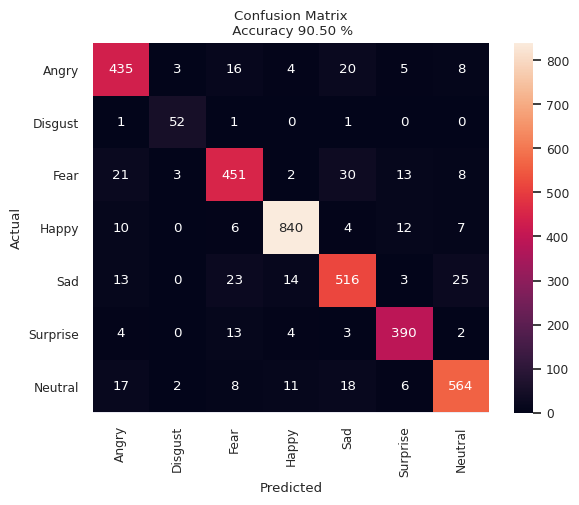

In [33]:
CLASS = ['Angry','Disgust','Fear','Happy','Sad', 'Surprise', 'Neutral'] 
    
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred) * 100

sns.set(font_scale=.8)
sns.heatmap(cm, annot=True, xticklabels=CLASS, yticklabels=CLASS, fmt='.0f')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title(f'Confusion Matrix\n Accuracy {acc:0.2f} %')
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
    

In [45]:
efficient = build_model_efficient(lr=0.0001)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

model name    :  EfficientNetB0
learning rate :  1e-04


In [46]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB0_lr0001' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [47]:
epochs = 256
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])


Epoch 1/256
941/941 [==============================] - ETA: 0s - loss: 1.6518 - accuracy: 0.3626
Epoch 1: val_accuracy improved from -inf to 0.45500, saving model to models/EfficientNetB0_lr0001_20231120-012401.h5
941/941 [==============================] - 42s 38ms/step - loss: 1.6518 - accuracy: 0.3626 - val_loss: 1.4354 - val_accuracy: 0.4550
Epoch 2/256
940/941 [============================>.] - ETA: 0s - loss: 1.3400 - accuracy: 0.4920
Epoch 2: val_accuracy improved from 0.45500 to 0.51491, saving model to models/EfficientNetB0_lr0001_20231120-012401.h5
941/941 [==============================] - 34s 37ms/step - loss: 1.3401 - accuracy: 0.4920 - val_loss: 1.2788 - val_accuracy: 0.5149
Epoch 3/256
941/941 [==============================] - ETA: 0s - loss: 1.2029 - accuracy: 0.5454
Epoch 3: val_accuracy improved from 0.51491 to 0.55308, saving model to models/EfficientNetB0_lr0001_20231120-012401.h5
941/941 [==============================] - 34s 37ms/step - loss: 1.2029 - accuracy: 0.

report

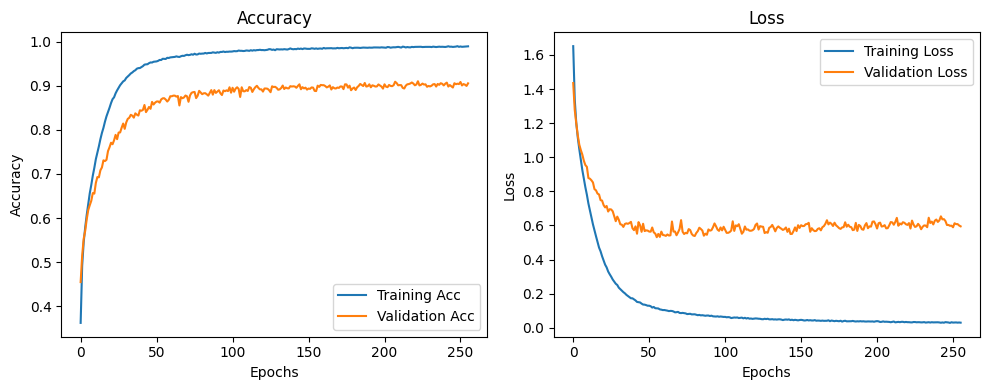

In [27]:
sns.reset_defaults()
model_name = 'EfficientNetB0_lr0001_20231120-012401'
plot = pd.read_csv(f'history_csv/{model_name}.csv')
display_evaluation_v2(plot, 'plot/' + model_name)

In [17]:
model_name = 'EfficientNetB0_lr0001_20231120-012401'
efficient = load_model(f'models/{model_name}.h5')

113/113 [==============================] - 2s 9ms/step - loss: 0.5058 - accuracy: 0.9114
test loss : 0.5058495998382568
test acc  : 0.9113959074020386
Confusion Matrix:
[[425   3  18   4  10   4  27]
 [  4  48   1   0   2   0   0]
 [ 22   1 455   3  21  11  15]
 [  7   1   9 839   6   5  12]
 [ 18   0  16   5 530   3  22]
 [  3   0   9   4   4 395   1]
 [ 14   0   7   7  15   4 579]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.86      0.87      0.86       491
     Disgust       0.91      0.87      0.89        55
        Fear       0.88      0.86      0.87       528
       Happy       0.97      0.95      0.96       879
         Sad       0.90      0.89      0.90       594
    Surprise       0.94      0.95      0.94       416
     Neutral       0.88      0.92      0.90       626

    accuracy                           0.91      3589
   macro avg       0.91      0.90      0.90      3589
weighted avg       0.91      0.91      0.91    

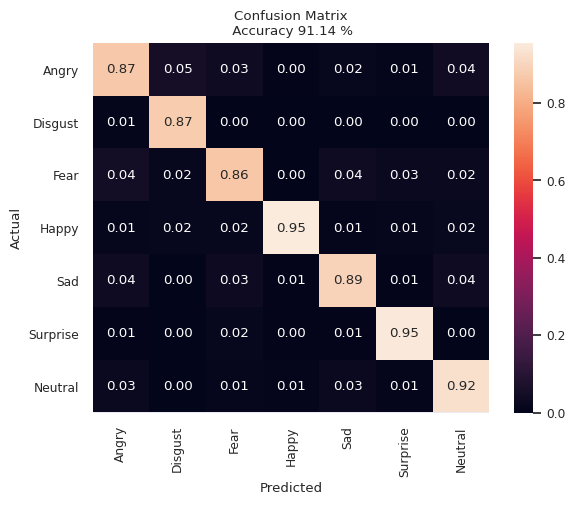

In [29]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred, save=True, name_file=f'plot/conf_{model_name}')

In [18]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred, digits=4)

113/113 [==============================] - 2s 9ms/step - loss: 0.5058 - accuracy: 0.9114
test loss : 0.5058495998382568
test acc  : 0.9113959074020386
Confusion Matrix:
[[425   3  18   4  10   4  27]
 [  4  48   1   0   2   0   0]
 [ 22   1 455   3  21  11  15]
 [  7   1   9 839   6   5  12]
 [ 18   0  16   5 530   3  22]
 [  3   0   9   4   4 395   1]
 [ 14   0   7   7  15   4 579]]

Classification Report:
              precision    recall  f1-score   support

       Angry     0.8621    0.8656    0.8638       491
     Disgust     0.9057    0.8727    0.8889        55
        Fear     0.8835    0.8617    0.8725       528
       Happy     0.9733    0.9545    0.9638       879
         Sad     0.9014    0.8923    0.8968       594
    Surprise     0.9360    0.9495    0.9427       416
     Neutral     0.8826    0.9249    0.9033       626

    accuracy                         0.9114      3589
   macro avg     0.9064    0.9030    0.9045      3589
weighted avg     0.9118    0.9114    0.9115    

In [30]:
y_pred, y_true = get_predict(efficient, x_val, y_val)

show_report(y_true, y_pred)

113/113 [==============================] - 1s 9ms/step - loss: 0.5821 - accuracy: 0.9100
test loss : 0.5820906758308411
test acc  : 0.9100027680397034
Confusion Matrix:
[[412   1  13   8  17   4  12]
 [  2  51   1   0   1   0   1]
 [ 14   0 427   2  19  19  15]
 [  5   0   6 859   7   7  11]
 [ 13   1  11  14 572   4  38]
 [  5   0   8   2   1 399   0]
 [ 15   1   9  10  25   1 546]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.88      0.88      0.88       467
     Disgust       0.94      0.91      0.93        56
        Fear       0.90      0.86      0.88       496
       Happy       0.96      0.96      0.96       895
         Sad       0.89      0.88      0.88       653
    Surprise       0.92      0.96      0.94       415
     Neutral       0.88      0.90      0.89       607

    accuracy                           0.91      3589
   macro avg       0.91      0.91      0.91      3589
weighted avg       0.91      0.91      0.91    

In [186]:
efficient = build_model_efficient(lr=0.00001)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

model name    :  EfficientNetB0
learning rate :  1e-05


In [187]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB0_lr00001' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [ ]:
epochs = 256
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])


Epoch 1/256
941/941 [==============================] - ETA: 0s - loss: 1.9979 - accuracy: 0.2083
Epoch 1: val_accuracy improved from -inf to 0.26832, saving model to models/EfficientNetB0_lr00001_20231207-032055.h5
941/941 [==============================] - 43s 39ms/step - loss: 1.9979 - accuracy: 0.2083 - val_loss: 1.8652 - val_accuracy: 0.2683
Epoch 2/256
941/941 [==============================] - ETA: 0s - loss: 1.8252 - accuracy: 0.2833
Epoch 2: val_accuracy improved from 0.26832 to 0.32321, saving model to models/EfficientNetB0_lr00001_20231207-032055.h5
941/941 [==============================] - 35s 37ms/step - loss: 1.8252 - accuracy: 0.2833 - val_loss: 1.7457 - val_accuracy: 0.3232
Epoch 3/256
940/941 [============================>.] - ETA: 0s - loss: 1.7279 - accuracy: 0.3336
Epoch 3: val_accuracy improved from 0.32321 to 0.35414, saving model to models/EfficientNetB0_lr00001_20231207-032055.h5
941/941 [==============================] - 36s 38ms/step - loss: 1.7279 - accuracy:

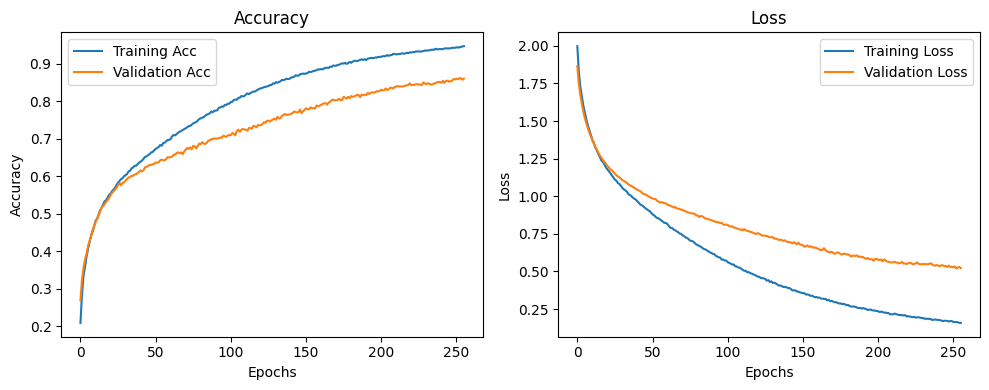

In [189]:
sns.reset_defaults()
model_name = 'EfficientNetB0_lr00001_20231207-032055'
plot = pd.read_csv(f'history_csv/{model_name}.csv')
display_evaluation_v2(plot, 'plot/' + model_name)

In [190]:
model_name = 'EfficientNetB0_lr00001_20231207-032055'
efficient = load_model(f'models/{model_name}.h5')

113/113 [==============================] - 2s 9ms/step - loss: 0.4829 - accuracy: 0.8610
test loss : 0.48288047313690186
test acc  : 0.8609640598297119
Confusion Matrix:
[[405   5  23   2  21   4  31]
 [  6  47   0   0   1   0   1]
 [ 28   2 418   4  36  19  21]
 [ 19   1  14 804   9   6  26]
 [ 29   0  26  15 488   4  32]
 [  4   0  17   9   3 378   5]
 [ 11   1  16  14  26   8 550]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.81      0.82      0.82       491
     Disgust       0.84      0.85      0.85        55
        Fear       0.81      0.79      0.80       528
       Happy       0.95      0.91      0.93       879
         Sad       0.84      0.82      0.83       594
    Surprise       0.90      0.91      0.91       416
     Neutral       0.83      0.88      0.85       626

    accuracy                           0.86      3589
   macro avg       0.85      0.86      0.85      3589
weighted avg       0.86      0.86      0.86   

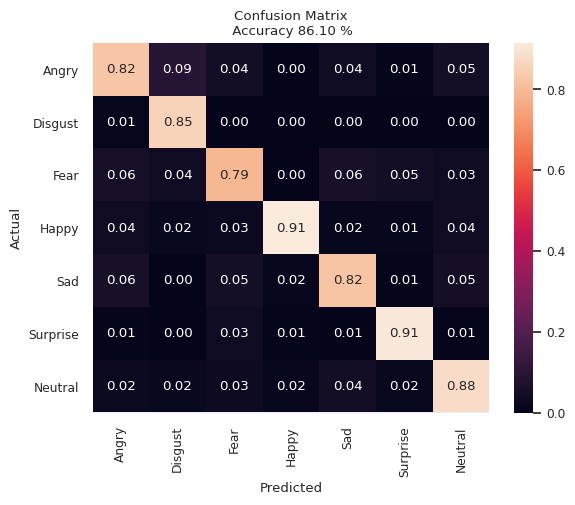

In [191]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred, save=True, name_file=f'plot/conf_{model_name}')

In [192]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred, digits=4)

113/113 [==============================] - 1s 9ms/step - loss: 0.4829 - accuracy: 0.8610
test loss : 0.48288047313690186
test acc  : 0.8609640598297119
Confusion Matrix:
[[405   5  23   2  21   4  31]
 [  6  47   0   0   1   0   1]
 [ 28   2 418   4  36  19  21]
 [ 19   1  14 804   9   6  26]
 [ 29   0  26  15 488   4  32]
 [  4   0  17   9   3 378   5]
 [ 11   1  16  14  26   8 550]]

Classification Report:
              precision    recall  f1-score   support

       Angry     0.8068    0.8248    0.8157       491
     Disgust     0.8393    0.8545    0.8468        55
        Fear     0.8132    0.7917    0.8023       528
       Happy     0.9481    0.9147    0.9311       879
         Sad     0.8356    0.8215    0.8285       594
    Surprise     0.9021    0.9087    0.9054       416
     Neutral     0.8258    0.8786    0.8514       626

    accuracy                         0.8610      3589
   macro avg     0.8530    0.8564    0.8545      3589
weighted avg     0.8620    0.8610    0.8612   

In [40]:
def build_model_efficientB7(lr=0.001):
    #model EfficientNetB0
    efficient = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    efficient.trainable = True

    x = efficient.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(7, activation='softmax')(x)

    efficient = Model(inputs=efficient.input, outputs=output, name="EfficientNetB7")
    efficient.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    efficient.summary()
    
    return efficient

In [41]:
efficient = build_model_efficientB7(lr=0.0001)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

Model: "EfficientNetB7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling_2 (Rescaling)        (None, 48, 48, 3)    0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 48, 48, 3)   7           ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.truediv_3 (TFOpLambda)  (None, 48, 48, 3)   0           ['normalization_2[0]

In [113]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB7_lr0001' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [18]:
#plan epoch 96 est 1 jam

epochs = 96
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/96


2023-11-24 04:48:43.400442: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-11-24 04:48:44.931324: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


941/941 [==============================] - ETA: 0s - loss: 1.5258 - accuracy: 0.4083
Epoch 1: val_accuracy improved from -inf to 0.51017, saving model to models/EfficientNetB6_lr0001_20231124-044612.h5
941/941 [==============================] - 124s 110ms/step - loss: 1.5258 - accuracy: 0.4083 - val_loss: 1.2784 - val_accuracy: 0.5102
Epoch 2/96
941/941 [==============================] - ETA: 0s - loss: 1.1920 - accuracy: 0.5475
Epoch 2: val_accuracy improved from 0.51017 to 0.58094, saving model to models/EfficientNetB6_lr0001_20231124-044612.h5
941/941 [==============================] - 96s 102ms/step - loss: 1.1920 - accuracy: 0.5475 - val_loss: 1.1116 - val_accuracy: 0.5809
Epoch 3/96
941/941 [==============================] - ETA: 0s - loss: 1.0418 - accuracy: 0.6073
Epoch 3: val_accuracy improved from 0.58094 to 0.61493, saving model to models/EfficientNetB6_lr0001_20231124-044612.h5
941/941 [==============================] - 95s 101ms/step - loss: 1.0418 - accuracy: 0.6073 - val

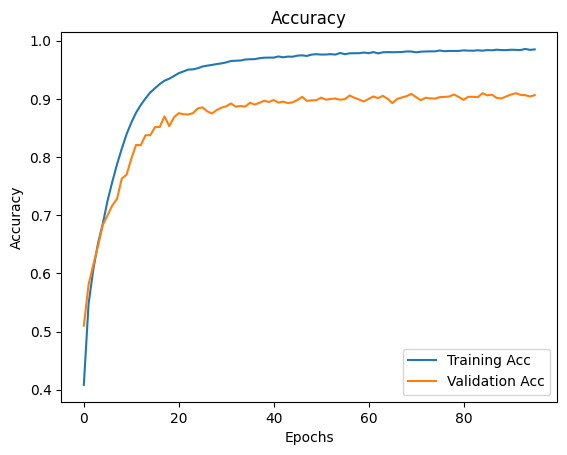

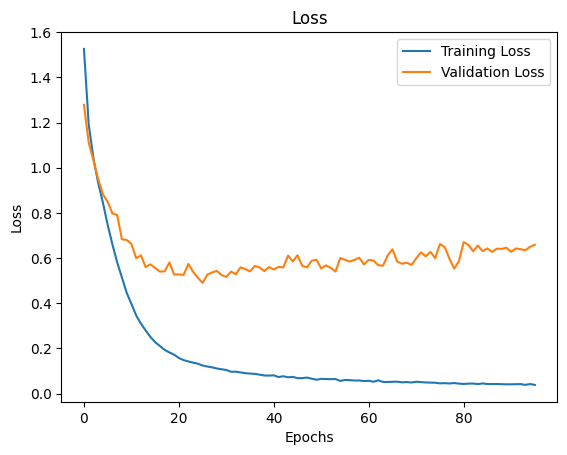

In [19]:
display_evaluation(hist.history)

113/113 [==============================] - 5s 23ms/step
Confusion Matrix:
[[436   2  20   6  16   1  10]
 [  5  49   1   0   0   0   0]
 [ 20   0 469   2  16   9  12]
 [  1   0   4 854   3   3  14]
 [ 14   0  20  13 524   1  22]
 [  3   0   8   8   4 389   4]
 [  6   0   8   6  17   2 587]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.90      0.89      0.89       491
     Disgust       0.96      0.89      0.92        55
        Fear       0.88      0.89      0.89       528
       Happy       0.96      0.97      0.97       879
         Sad       0.90      0.88      0.89       594
    Surprise       0.96      0.94      0.95       416
     Neutral       0.90      0.94      0.92       626

    accuracy                           0.92      3589
   macro avg       0.92      0.91      0.92      3589
weighted avg       0.92      0.92      0.92      3589



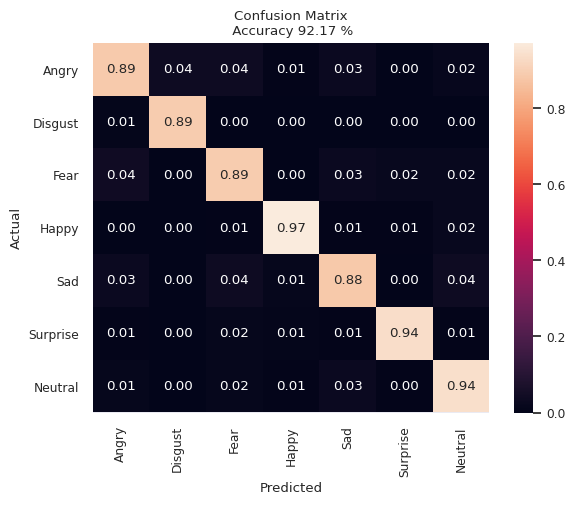

In [20]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred)

In [43]:
def build_model_efficientB6(lr=0.001):
    #model EfficientNetB6
    efficient = EfficientNetB6(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    efficient.trainable = True

    x = efficient.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(7, activation='softmax')(x)

    efficient = Model(inputs=efficient.input, outputs=output, name="EfficientNetB6")
    efficient.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    efficient.summary()
    
    return efficient

In [44]:
efficient = build_model_efficientB6(lr=0.0001)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

Model: "EfficientNetB6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling_3 (Rescaling)        (None, 48, 48, 3)    0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 48, 48, 3)   7           ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.truediv_5 (TFOpLambda)  (None, 48, 48, 3)   0           ['normalization_3[0]

In [23]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB6_lr0001' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [24]:
#plan epoch 96 est 1 jam

epochs = 128
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/128
941/941 [==============================] - ETA: 0s - loss: 1.5357 - accuracy: 0.4052
Epoch 1: val_accuracy improved from -inf to 0.49791, saving model to models/EfficientNetB6_lr0001_20231124-072209.h5
941/941 [==============================] - 122s 110ms/step - loss: 1.5357 - accuracy: 0.4052 - val_loss: 1.3083 - val_accuracy: 0.4979
Epoch 2/128
941/941 [==============================] - ETA: 0s - loss: 1.1968 - accuracy: 0.5480
Epoch 2: val_accuracy improved from 0.49791 to 0.57314, saving model to models/EfficientNetB6_lr0001_20231124-072209.h5
941/941 [==============================] - 98s 104ms/step - loss: 1.1968 - accuracy: 0.5480 - val_loss: 1.1179 - val_accuracy: 0.5731
Epoch 3/128
941/941 [==============================] - ETA: 0s - loss: 1.0478 - accuracy: 0.6048
Epoch 3: val_accuracy improved from 0.57314 to 0.61298, saving model to models/EfficientNetB6_lr0001_20231124-072209.h5
941/941 [==============================] - 97s 103ms/step - loss: 1.0478 - accuracy

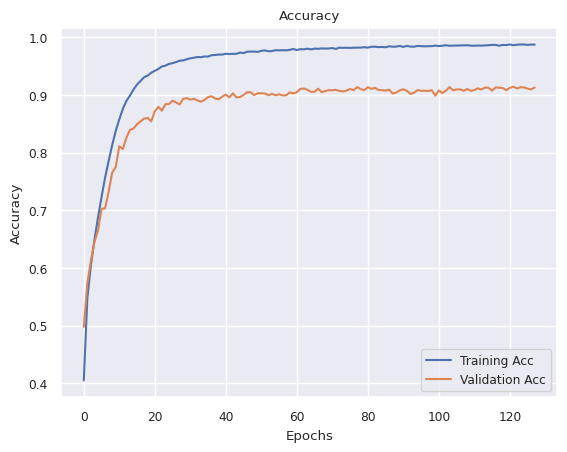

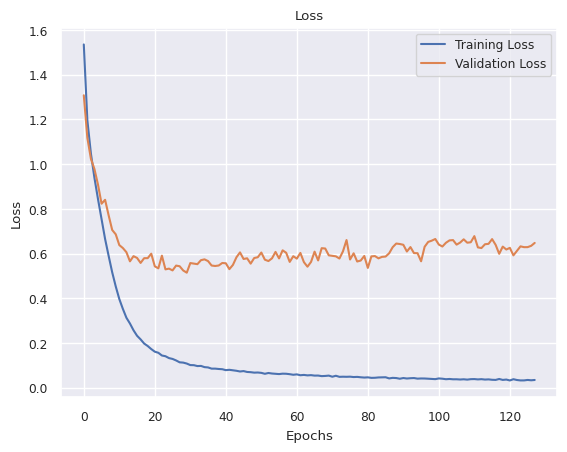

In [25]:
display_evaluation(hist.history)

113/113 [==============================] - 5s 23ms/step
Confusion Matrix:
[[436   1  22   4  16   3   9]
 [  5  50   0   0   0   0   0]
 [ 23   1 458   4  15  11  16]
 [  3   0   3 847   5   7  14]
 [ 12   1  19   7 533   1  21]
 [  1   0   6   6   2 400   1]
 [  5   0   6   8  19   4 584]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.90      0.89      0.89       491
     Disgust       0.94      0.91      0.93        55
        Fear       0.89      0.87      0.88       528
       Happy       0.97      0.96      0.97       879
         Sad       0.90      0.90      0.90       594
    Surprise       0.94      0.96      0.95       416
     Neutral       0.91      0.93      0.92       626

    accuracy                           0.92      3589
   macro avg       0.92      0.92      0.92      3589
weighted avg       0.92      0.92      0.92      3589



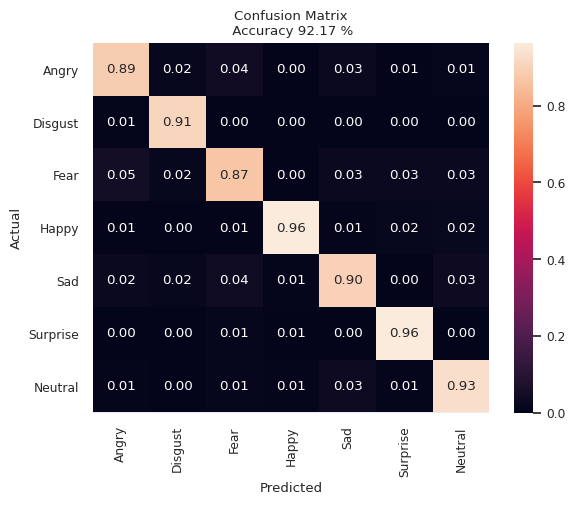

In [26]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred)

In [45]:
def build_model_efficientB5(lr=0.001):
    #model EfficientNetB5
    efficient = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    efficient.trainable = True

    x = efficient.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(7, activation='softmax')(x)

    efficient = Model(inputs=efficient.input, outputs=output, name="EfficientNetB5")
    efficient.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    efficient.summary()
    
    return efficient

In [39]:
efficient = build_model_efficientB5(lr=0.0001)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

Model: "EfficientNetB5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 48, 48, 3)    0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 48, 48, 3)   7           ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.truediv_2 (TFOpLambda)  (None, 48, 48, 3)   0           ['normalization_1[0]

In [14]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB5_lr0001' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [15]:
#plan epoch 96 est 1 jam

epochs = 128
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/128


2023-11-25 14:03:20.207423: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-11-25 14:03:21.738102: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


941/941 [==============================] - ETA: 0s - loss: 1.6085 - accuracy: 0.3757
Epoch 1: val_accuracy improved from -inf to 0.47785, saving model to models/EfficientNetB5_lr0001_20231125-140259.h5
941/941 [==============================] - 108s 95ms/step - loss: 1.6085 - accuracy: 0.3757 - val_loss: 1.3531 - val_accuracy: 0.4778
Epoch 2/128
941/941 [==============================] - ETA: 0s - loss: 1.2602 - accuracy: 0.5215
Epoch 2: val_accuracy improved from 0.47785 to 0.55809, saving model to models/EfficientNetB5_lr0001_20231125-140259.h5
941/941 [==============================] - 82s 88ms/step - loss: 1.2602 - accuracy: 0.5215 - val_loss: 1.1688 - val_accuracy: 0.5581
Epoch 3/128
941/941 [==============================] - ETA: 0s - loss: 1.1097 - accuracy: 0.5839
Epoch 3: val_accuracy improved from 0.55809 to 0.59877, saving model to models/EfficientNetB5_lr0001_20231125-140259.h5
941/941 [==============================] - 82s 87ms/step - loss: 1.1097 - accuracy: 0.5839 - val_

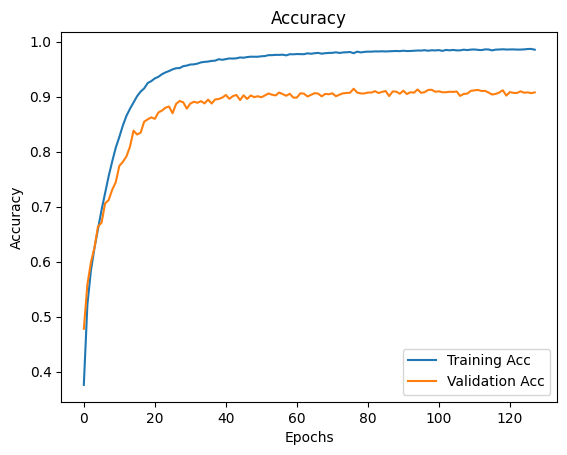

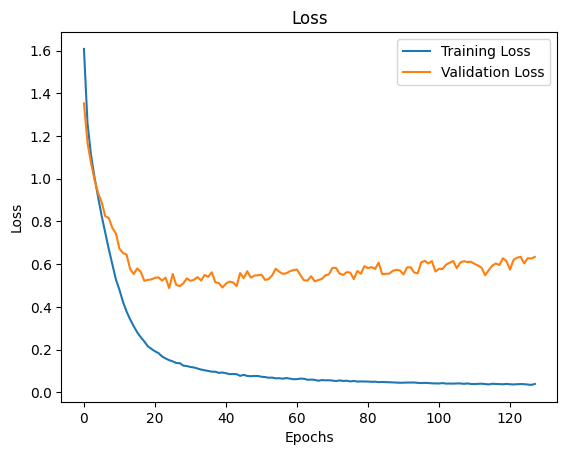

In [16]:
display_evaluation(hist.history)

113/113 [==============================] - 4s 19ms/step
Confusion Matrix:
[[430   2  21   4  16   5  13]
 [  4  51   0   0   0   0   0]
 [ 17   1 467   2  23   8  10]
 [ 11   0   7 836   6   7  12]
 [ 15   1  15   9 524   1  29]
 [  0   0   7   5   4 396   4]
 [  8   0   8  11  12   2 585]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.89      0.88      0.88       491
     Disgust       0.93      0.93      0.93        55
        Fear       0.89      0.88      0.89       528
       Happy       0.96      0.95      0.96       879
         Sad       0.90      0.88      0.89       594
    Surprise       0.95      0.95      0.95       416
     Neutral       0.90      0.93      0.91       626

    accuracy                           0.92      3589
   macro avg       0.91      0.92      0.92      3589
weighted avg       0.92      0.92      0.92      3589



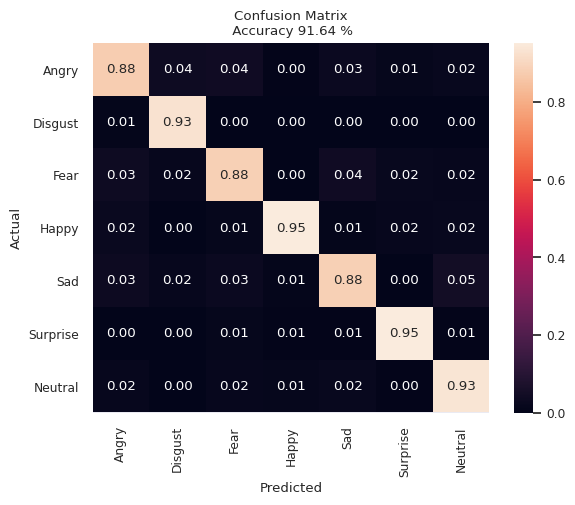

In [17]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred)

In [47]:
def build_model_efficientB4(lr=0.001):
    #model EfficientNetB4
    efficient = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    efficient.trainable = True

    x = efficient.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(7, activation='softmax')(x)

    efficient = Model(inputs=efficient.input, outputs=output, name="EfficientNetB4")
    efficient.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    efficient.summary()
    
    return efficient

In [48]:
efficient = build_model_efficientB4(lr=0.0001)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

Model: "EfficientNetB4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling_4 (Rescaling)        (None, 48, 48, 3)    0           ['input_5[0][0]']                
                                                                                                  
 normalization_4 (Normalization  (None, 48, 48, 3)   7           ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.truediv_6 (TFOpLambda)  (None, 48, 48, 3)   0           ['normalization_4[0]

In [20]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB4_lr0001' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [21]:
#plan epoch 96 est 1 jam

epochs = 128
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/128
941/941 [==============================] - ETA: 0s - loss: 1.6023 - accuracy: 0.3778
Epoch 1: val_accuracy improved from -inf to 0.48119, saving model to models/EfficientNetB4_lr0001_20231125-181149.h5
941/941 [==============================] - 86s 77ms/step - loss: 1.6023 - accuracy: 0.3778 - val_loss: 1.3561 - val_accuracy: 0.4812
Epoch 2/128
941/941 [==============================] - ETA: 0s - loss: 1.2751 - accuracy: 0.5149
Epoch 2: val_accuracy improved from 0.48119 to 0.55475, saving model to models/EfficientNetB4_lr0001_20231125-181149.h5
941/941 [==============================] - 67s 72ms/step - loss: 1.2751 - accuracy: 0.5149 - val_loss: 1.1748 - val_accuracy: 0.5548
Epoch 3/128
941/941 [==============================] - ETA: 0s - loss: 1.1294 - accuracy: 0.5756
Epoch 3: val_accuracy improved from 0.55475 to 0.58902, saving model to models/EfficientNetB4_lr0001_20231125-181149.h5
941/941 [==============================] - 68s 72ms/step - loss: 1.1294 - accuracy: 0.

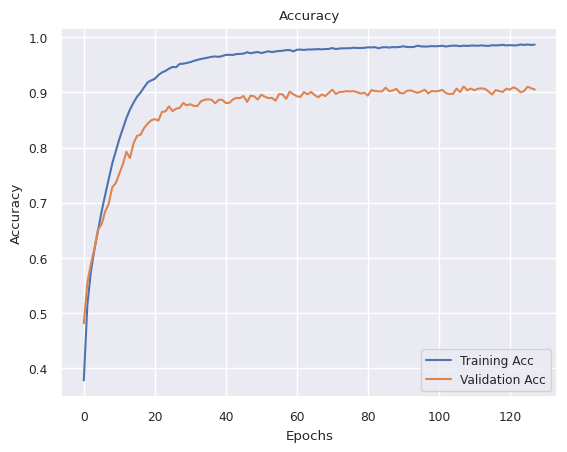

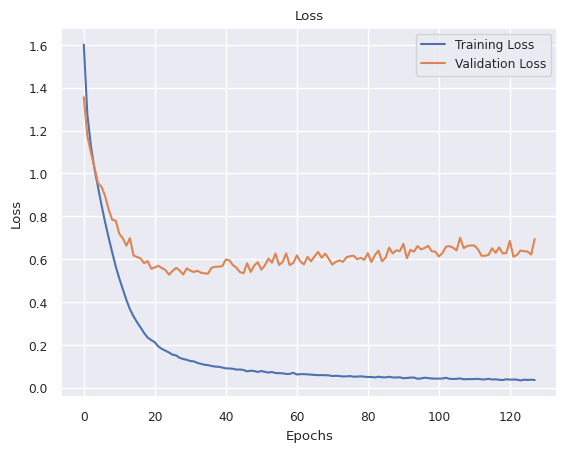

In [22]:
display_evaluation(hist.history)

113/113 [==============================] - 4s 17ms/step
Confusion Matrix:
[[435   3  17   4  15   4  13]
 [  5  49   0   0   1   0   0]
 [ 16   1 464   3  22  12  10]
 [  9   1   4 842   5   8  10]
 [ 14   0  20  12 523   1  24]
 [  6   0  10   5   3 390   2]
 [ 12   1  10  12  20   5 566]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.88      0.89      0.88       491
     Disgust       0.89      0.89      0.89        55
        Fear       0.88      0.88      0.88       528
       Happy       0.96      0.96      0.96       879
         Sad       0.89      0.88      0.88       594
    Surprise       0.93      0.94      0.93       416
     Neutral       0.91      0.90      0.90       626

    accuracy                           0.91      3589
   macro avg       0.90      0.91      0.90      3589
weighted avg       0.91      0.91      0.91      3589



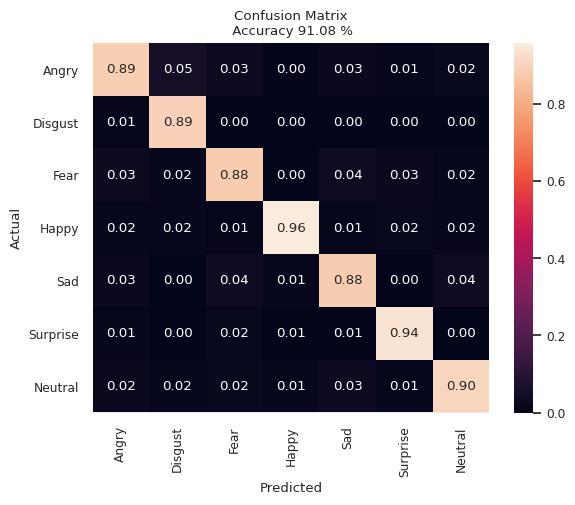

In [23]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred)

In [49]:
def build_model_efficientB3(lr=0.001):
    #model EfficientNetB3
    efficient = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    efficient.trainable = True

    x = efficient.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(7, activation='softmax')(x)

    efficient = Model(inputs=efficient.input, outputs=output, name="EfficientNetB3")
    efficient.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    efficient.summary()
    
    return efficient

In [50]:
efficient = build_model_efficientB3(lr=0.0001)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

Model: "EfficientNetB3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling_5 (Rescaling)        (None, 48, 48, 3)    0           ['input_6[0][0]']                
                                                                                                  
 normalization_5 (Normalization  (None, 48, 48, 3)   7           ['rescaling_5[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.truediv_7 (TFOpLambda)  (None, 48, 48, 3)   0           ['normalization_5[0]

In [26]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB3_lr0001' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [27]:
#plan epoch 96 est 1 jam

epochs = 128
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/128
941/941 [==============================] - ETA: 0s - loss: 1.6748 - accuracy: 0.3568
Epoch 1: val_accuracy improved from -inf to 0.45249, saving model to models/EfficientNetB3_lr0001_20231125-203518.h5
941/941 [==============================] - 69s 61ms/step - loss: 1.6748 - accuracy: 0.3568 - val_loss: 1.4283 - val_accuracy: 0.4525
Epoch 2/128
941/941 [==============================] - ETA: 0s - loss: 1.3421 - accuracy: 0.4885
Epoch 2: val_accuracy improved from 0.45249 to 0.51714, saving model to models/EfficientNetB3_lr0001_20231125-203518.h5
941/941 [==============================] - 55s 58ms/step - loss: 1.3421 - accuracy: 0.4885 - val_loss: 1.2647 - val_accuracy: 0.5171
Epoch 3/128
941/941 [==============================] - ETA: 0s - loss: 1.1873 - accuracy: 0.5500
Epoch 3: val_accuracy improved from 0.51714 to 0.56840, saving model to models/EfficientNetB3_lr0001_20231125-203518.h5
941/941 [==============================] - 56s 60ms/step - loss: 1.1873 - accuracy: 0.

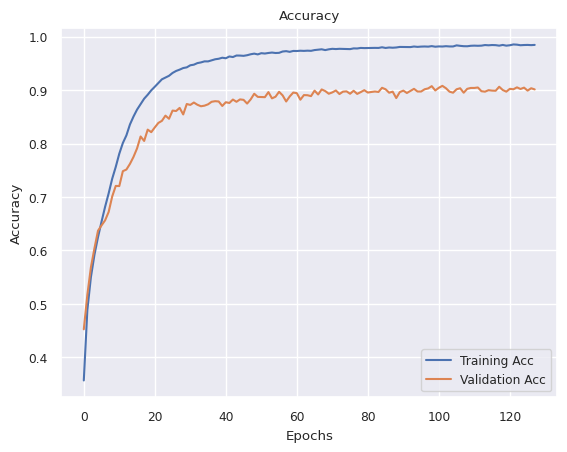

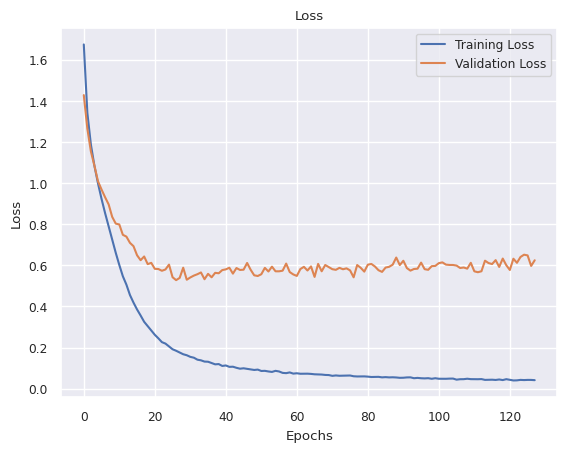

In [28]:
display_evaluation(hist.history)

113/113 [==============================] - 3s 13ms/step
Confusion Matrix:
[[438   5  14   2  17   4  11]
 [  5  48   0   0   1   0   1]
 [ 19   1 462   5  21  15   5]
 [  7   1   5 848   4   8   6]
 [ 20   1  20  10 518   3  22]
 [  3   0  10   4   4 392   3]
 [  9   0   7   7  17   6 580]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.87      0.89      0.88       491
     Disgust       0.86      0.87      0.86        55
        Fear       0.89      0.88      0.88       528
       Happy       0.97      0.96      0.97       879
         Sad       0.89      0.87      0.88       594
    Surprise       0.92      0.94      0.93       416
     Neutral       0.92      0.93      0.93       626

    accuracy                           0.92      3589
   macro avg       0.90      0.91      0.90      3589
weighted avg       0.92      0.92      0.92      3589



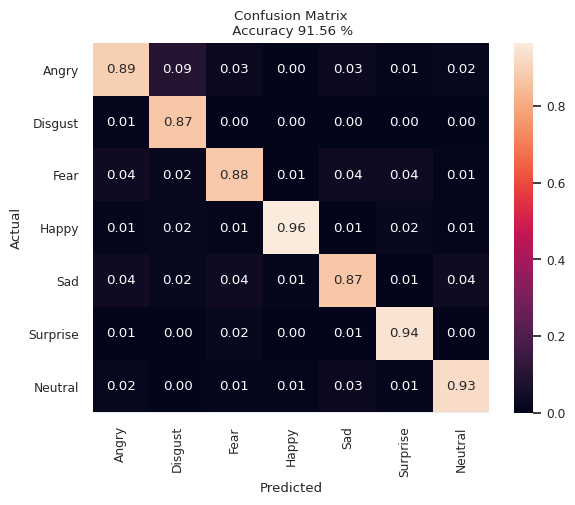

In [29]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred)

In [53]:
def build_model_efficientB2(lr=0.001):
    #model EfficientNetB2
    efficient = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    efficient.trainable = True

    x = efficient.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(7, activation='softmax')(x)

    efficient = Model(inputs=efficient.input, outputs=output, name="EfficientNetB2")
    efficient.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    efficient.summary()
    
    return efficient

In [54]:
efficient = build_model_efficientB2(lr=0.0001)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

Model: "EfficientNetB2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling_7 (Rescaling)        (None, 48, 48, 3)    0           ['input_8[0][0]']                
                                                                                                  
 normalization_7 (Normalization  (None, 48, 48, 3)   7           ['rescaling_7[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.truediv_9 (TFOpLambda)  (None, 48, 48, 3)   0           ['normalization_7[0]

In [32]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB2_lr0001' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [33]:
#plan epoch 96 est 1 jam

epochs = 128
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/128
941/941 [==============================] - ETA: 0s - loss: 1.6986 - accuracy: 0.3462
Epoch 1: val_accuracy improved from -inf to 0.42073, saving model to models/EfficientNetB2_lr0001_20231125-223211.h5
941/941 [==============================] - 59s 53ms/step - loss: 1.6986 - accuracy: 0.3462 - val_loss: 1.4902 - val_accuracy: 0.4207
Epoch 2/128
940/941 [============================>.] - ETA: 0s - loss: 1.3754 - accuracy: 0.4795
Epoch 2: val_accuracy improved from 0.42073 to 0.49568, saving model to models/EfficientNetB2_lr0001_20231125-223211.h5
941/941 [==============================] - 47s 50ms/step - loss: 1.3756 - accuracy: 0.4795 - val_loss: 1.3083 - val_accuracy: 0.4957
Epoch 3/128
940/941 [============================>.] - ETA: 0s - loss: 1.2149 - accuracy: 0.5413
Epoch 3: val_accuracy improved from 0.49568 to 0.55642, saving model to models/EfficientNetB2_lr0001_20231125-223211.h5
941/941 [==============================] - 48s 51ms/step - loss: 1.2148 - accuracy: 0.

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



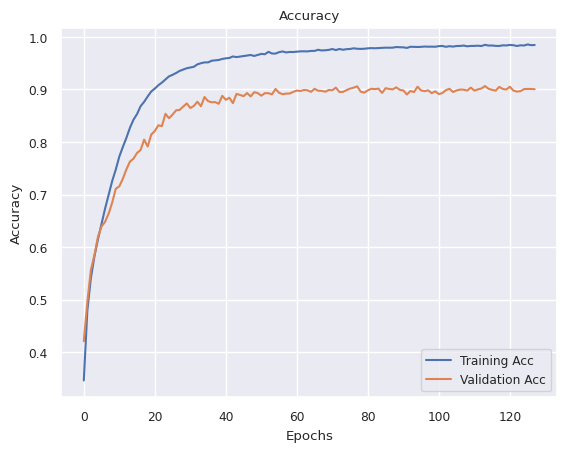

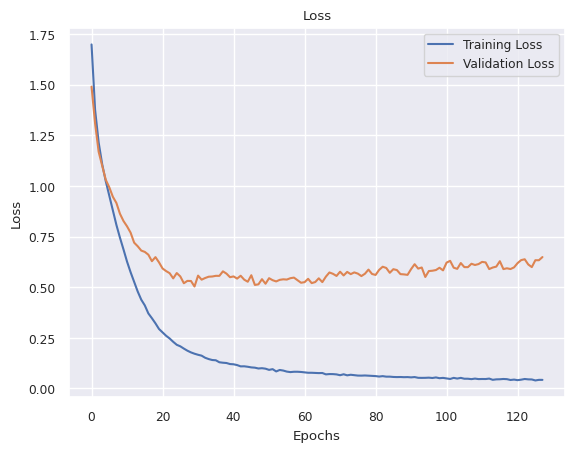

In [34]:
display_evaluation(hist.history)

113/113 [==============================] - 3s 13ms/step
Confusion Matrix:
[[436   2  20   2  13   3  15]
 [  6  48   1   0   0   0   0]
 [ 24   0 456   2  18  13  15]
 [  9   0   4 820   9  12  25]
 [ 10   0  14   7 531   3  29]
 [  2   0  10   5   3 394   2]
 [  5   1  15   3  11   3 588]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.89      0.89      0.89       491
     Disgust       0.94      0.87      0.91        55
        Fear       0.88      0.86      0.87       528
       Happy       0.98      0.93      0.95       879
         Sad       0.91      0.89      0.90       594
    Surprise       0.92      0.95      0.93       416
     Neutral       0.87      0.94      0.90       626

    accuracy                           0.91      3589
   macro avg       0.91      0.91      0.91      3589
weighted avg       0.91      0.91      0.91      3589



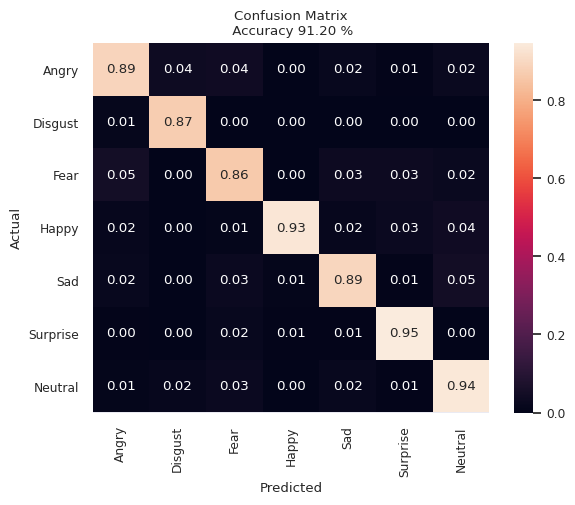

In [35]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred)

In [43]:
def build_model_efficientB2(lr=0.001):
    #model EfficientNetB2
    efficient = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    efficient.trainable = True

    x = efficient.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(7, activation='softmax')(x)

    efficient = Model(inputs=efficient.input, outputs=output, name="EfficientNetB2")
    efficient.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    # effcient.summary()
    
    return efficient

In [44]:
efficient = build_model_efficientB2(lr=0.0001)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

model name    :  EfficientNetB2
learning rate :  1e-04


In [45]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB2_lr0001' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [46]:
#plan epoch 96 est 1 jam

epochs = 128
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/128
941/941 [==============================] - ETA: 0s - loss: 1.7065 - accuracy: 0.3409
Epoch 1: val_accuracy improved from -inf to 0.43188, saving model to models/EfficientNetB2_lr0001_20231126-041355.h5
941/941 [==============================] - 59s 53ms/step - loss: 1.7065 - accuracy: 0.3409 - val_loss: 1.4824 - val_accuracy: 0.4319
Epoch 2/128
941/941 [==============================] - ETA: 0s - loss: 1.3771 - accuracy: 0.4761
Epoch 2: val_accuracy improved from 0.43188 to 0.50571, saving model to models/EfficientNetB2_lr0001_20231126-041355.h5
941/941 [==============================] - 48s 51ms/step - loss: 1.3771 - accuracy: 0.4761 - val_loss: 1.2993 - val_accuracy: 0.5057
Epoch 3/128
941/941 [==============================] - ETA: 0s - loss: 1.2195 - accuracy: 0.5364
Epoch 3: val_accuracy improved from 0.50571 to 0.54862, saving model to models/EfficientNetB2_lr0001_20231126-041355.h5
941/941 [==============================] - 48s 51ms/step - loss: 1.2195 - accuracy: 0.

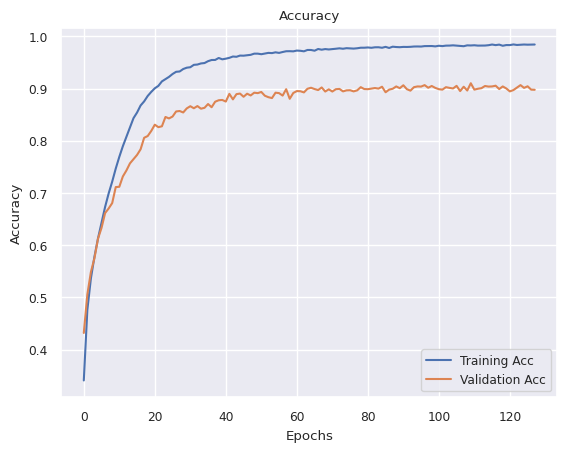

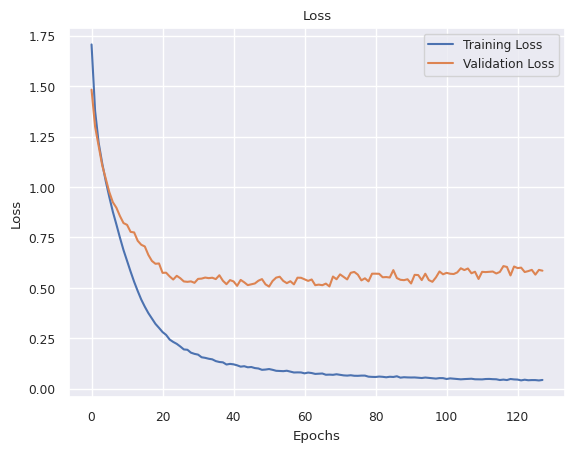

In [47]:
display_evaluation(hist.history)

113/113 [==============================] - 3s 11ms/step
Confusion Matrix:
[[431   2  24   1  19   2  12]
 [  5  50   0   0   0   0   0]
 [ 24   3 455   3  22  13   8]
 [ 10   1   7 838   8   7   8]
 [ 13   0  21   9 527   2  22]
 [  1   0   9   5   4 395   2]
 [ 11   0  14   7  23   7 564]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.87      0.88      0.87       491
     Disgust       0.89      0.91      0.90        55
        Fear       0.86      0.86      0.86       528
       Happy       0.97      0.95      0.96       879
         Sad       0.87      0.89      0.88       594
    Surprise       0.93      0.95      0.94       416
     Neutral       0.92      0.90      0.91       626

    accuracy                           0.91      3589
   macro avg       0.90      0.91      0.90      3589
weighted avg       0.91      0.91      0.91      3589



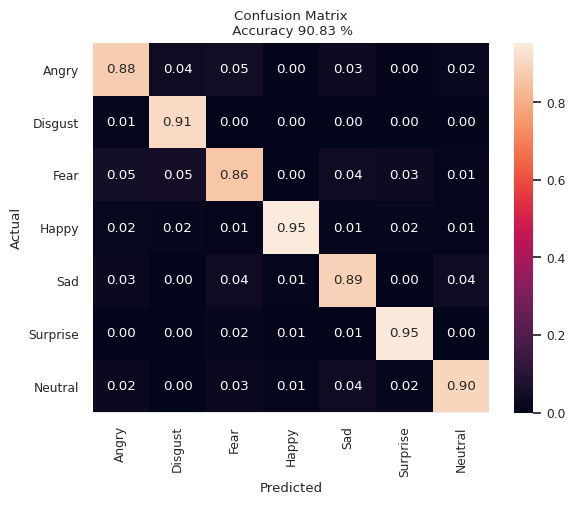

In [48]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred)

In [56]:
def build_model_efficientB1(lr=0.001):
    #model EfficientNetB1
    efficient = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    efficient.trainable = True

    x = efficient.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(7, activation='softmax')(x)

    efficient = Model(inputs=efficient.input, outputs=output, name="EfficientNetB1")
    efficient.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    efficient.summary()
    
    return efficient

In [57]:
efficient = build_model_efficientB1(lr=0.0001)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

Model: "EfficientNetB1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling_8 (Rescaling)        (None, 48, 48, 3)    0           ['input_9[0][0]']                
                                                                                                  
 normalization_8 (Normalization  (None, 48, 48, 3)   7           ['rescaling_8[0][0]']            
 )                                                                                                
                                                                                                  
 tf.math.truediv_10 (TFOpLambda  (None, 48, 48, 3)   0           ['normalization_8[0]

In [39]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB1_lr0001' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [40]:
#plan epoch 96 est 1 jam

epochs = 128
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/128
940/941 [============================>.] - ETA: 0s - loss: 1.6854 - accuracy: 0.3491
Epoch 1: val_accuracy improved from -inf to 0.44469, saving model to models/EfficientNetB1_lr0001_20231126-023427.h5
941/941 [==============================] - 58s 51ms/step - loss: 1.6852 - accuracy: 0.3491 - val_loss: 1.4497 - val_accuracy: 0.4447
Epoch 2/128
940/941 [============================>.] - ETA: 0s - loss: 1.3521 - accuracy: 0.4866
Epoch 2: val_accuracy improved from 0.44469 to 0.52132, saving model to models/EfficientNetB1_lr0001_20231126-023427.h5
941/941 [==============================] - 47s 49ms/step - loss: 1.3521 - accuracy: 0.4866 - val_loss: 1.2703 - val_accuracy: 0.5213
Epoch 3/128
941/941 [==============================] - ETA: 0s - loss: 1.2002 - accuracy: 0.5438
Epoch 3: val_accuracy improved from 0.52132 to 0.56060, saving model to models/EfficientNetB1_lr0001_20231126-023427.h5
941/941 [==============================] - 47s 49ms/step - loss: 1.2002 - accuracy: 0.

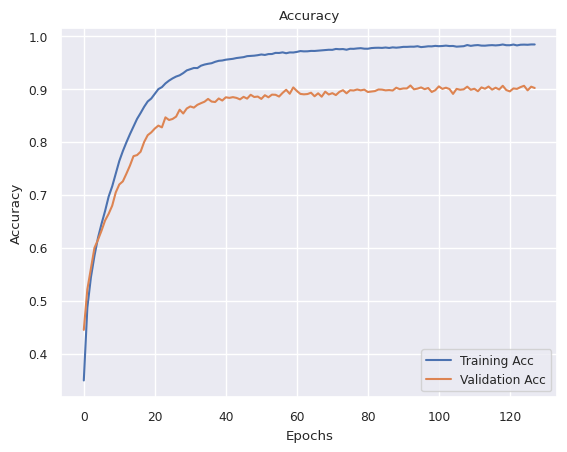

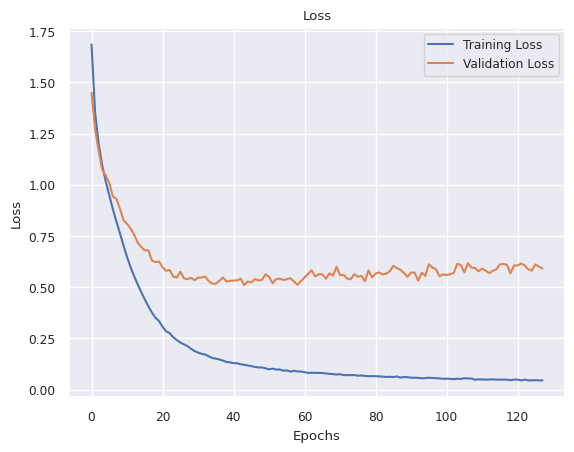

In [41]:
display_evaluation(hist.history)

113/113 [==============================] - 3s 11ms/step
Confusion Matrix:
[[427   2  19   2  21   3  17]
 [  4  49   0   0   2   0   0]
 [ 16   0 465   4  19  11  13]
 [  7   0   7 838   4   5  18]
 [ 15   1  18  12 519   1  28]
 [  6   0   6   5   3 391   5]
 [  8   0  12   4  21   3 578]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.88      0.87      0.88       491
     Disgust       0.94      0.89      0.92        55
        Fear       0.88      0.88      0.88       528
       Happy       0.97      0.95      0.96       879
         Sad       0.88      0.87      0.88       594
    Surprise       0.94      0.94      0.94       416
     Neutral       0.88      0.92      0.90       626

    accuracy                           0.91      3589
   macro avg       0.91      0.90      0.91      3589
weighted avg       0.91      0.91      0.91      3589



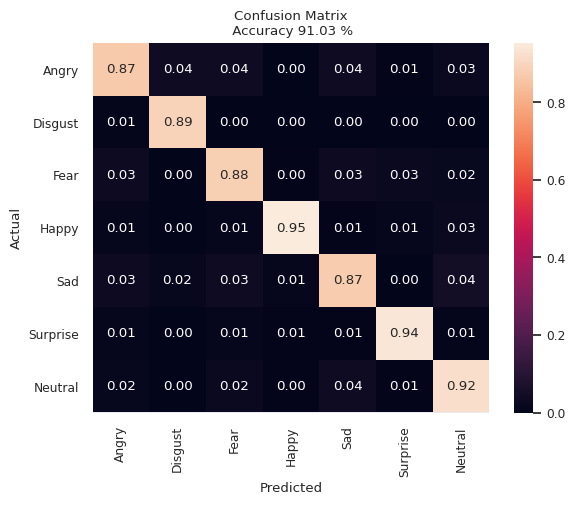

In [42]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred)

In [60]:
def build_model_efficient(lr=0.001):
    #model EfficientNetB0
    efficient = EfficientNetB0(weights='imagenet', 
                               include_top=False, 
                               input_shape=(48, 48, 3))
    efficient.trainable = True

    x = efficient.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(7, activation='softmax')(x)

    efficient = Model(inputs=efficient.input, 
                      outputs=output, 
                      name="EfficientNetB0")
    
    efficient.compile(optimizer=Adam(learning_rate=lr), 
                      loss='categorical_crossentropy', metrics=['accuracy'])

    return efficient

In [61]:
# set training parameter
batch_size = 32
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = (x_val, y_val)

In [62]:
efficient = build_model_efficient(lr=0.0001)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

model name    :  EfficientNetB0
learning rate :  1e-04


In [63]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB0_lr0001_Bath32' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [64]:
epochs = 128
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])


Epoch 1/128
1880/1881 [============================>.] - ETA: 0s - loss: 1.5922 - accuracy: 0.3884
Epoch 1: val_accuracy improved from -inf to 0.48091, saving model to models/EfficientNetB0_lr0001_Bath32_20231126-072416.h5
1881/1881 [==============================] - 69s 33ms/step - loss: 1.5920 - accuracy: 0.3885 - val_loss: 1.3620 - val_accuracy: 0.4809
Epoch 2/128
1881/1881 [==============================] - ETA: 0s - loss: 1.2865 - accuracy: 0.5138
Epoch 2: val_accuracy improved from 0.48091 to 0.55391, saving model to models/EfficientNetB0_lr0001_Bath32_20231126-072416.h5
1881/1881 [==============================] - 62s 33ms/step - loss: 1.2865 - accuracy: 0.5138 - val_loss: 1.2009 - val_accuracy: 0.5539
Epoch 3/128
1881/1881 [==============================] - ETA: 0s - loss: 1.1639 - accuracy: 0.5620
Epoch 3: val_accuracy improved from 0.55391 to 0.57927, saving model to models/EfficientNetB0_lr0001_Bath32_20231126-072416.h5
1881/1881 [==============================] - 61s 33ms/s

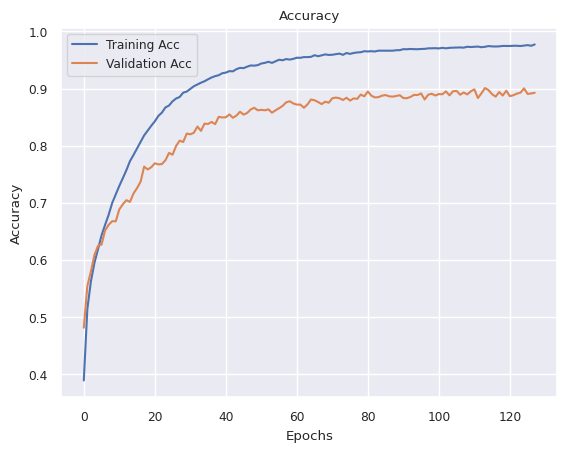

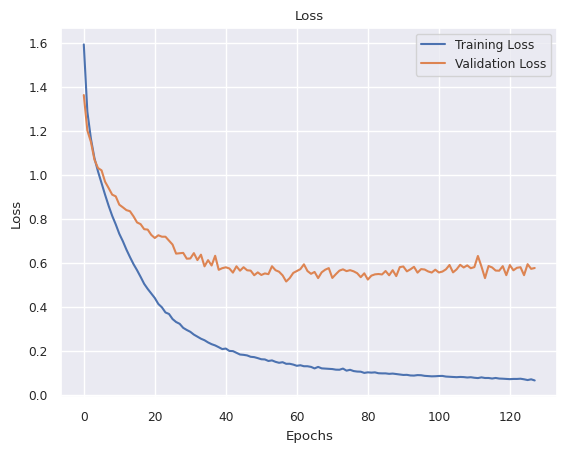

In [65]:
display_evaluation(hist.history)

113/113 [==============================] - 2s 8ms/step
Confusion Matrix:
[[435   3  15   3  17   3  15]
 [  1  52   1   0   1   0   0]
 [ 25   0 459   3  19  16   6]
 [ 15   2   6 827   6  12  11]
 [ 21   0  21   9 513   4  26]
 [  6   0  16   5   6 381   2]
 [ 12   1  15   8  16   1 573]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.84      0.89      0.86       491
     Disgust       0.90      0.95      0.92        55
        Fear       0.86      0.87      0.87       528
       Happy       0.97      0.94      0.95       879
         Sad       0.89      0.86      0.88       594
    Surprise       0.91      0.92      0.91       416
     Neutral       0.91      0.92      0.91       626

    accuracy                           0.90      3589
   macro avg       0.90      0.91      0.90      3589
weighted avg       0.90      0.90      0.90      3589



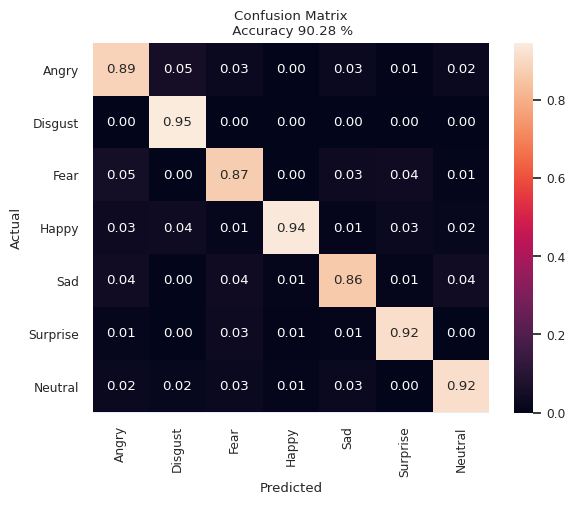

In [66]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred)

Batch 64

In [53]:
#last batch 64
epochs = 128
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])


Epoch 1/128
941/941 [==============================] - ETA: 0s - loss: 1.6539 - accuracy: 0.3590
Epoch 1: val_accuracy improved from -inf to 0.44581, saving model to models/EfficientNetB0_lr0001_Bath32_20231126-055542.h5
941/941 [==============================] - 43s 39ms/step - loss: 1.6539 - accuracy: 0.3590 - val_loss: 1.4440 - val_accuracy: 0.4458
Epoch 2/128
941/941 [==============================] - ETA: 0s - loss: 1.3487 - accuracy: 0.4862
Epoch 2: val_accuracy improved from 0.44581 to 0.50683, saving model to models/EfficientNetB0_lr0001_Bath32_20231126-055542.h5
941/941 [==============================] - 35s 37ms/step - loss: 1.3487 - accuracy: 0.4862 - val_loss: 1.2870 - val_accuracy: 0.5068
Epoch 3/128
940/941 [============================>.] - ETA: 0s - loss: 1.2157 - accuracy: 0.5395
Epoch 3: val_accuracy improved from 0.50683 to 0.55001, saving model to models/EfficientNetB0_lr0001_Bath32_20231126-055542.h5
941/941 [==============================] - 36s 38ms/step - loss: 

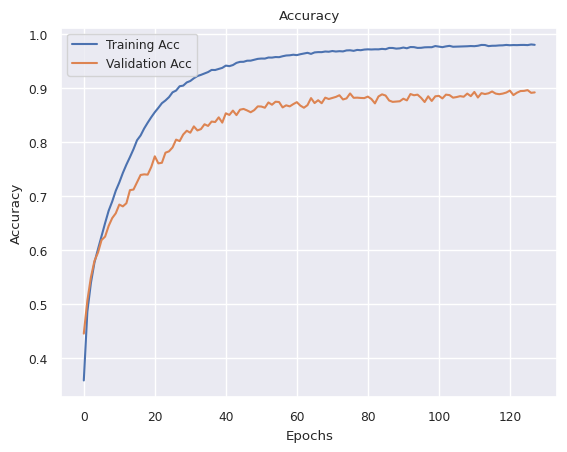

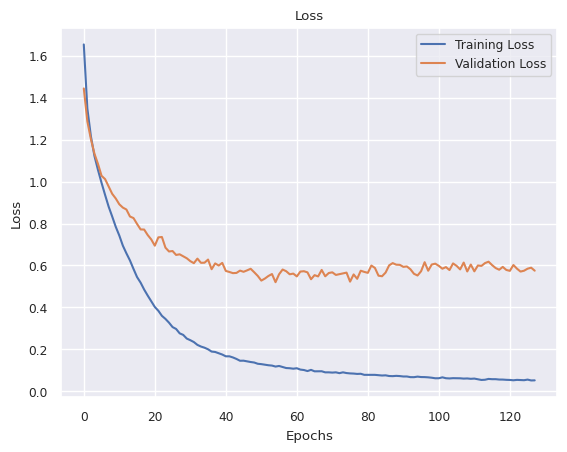

In [54]:
display_evaluation(hist.history)

113/113 [==============================] - 3s 8ms/step
Confusion Matrix:
[[441   3  18   1  14   1  13]
 [  6  48   1   0   0   0   0]
 [ 25   0 454   2  24  14   9]
 [  9   0   8 838   9   5  10]
 [ 19   1  19  11 515   1  28]
 [  7   0  17   3   5 382   2]
 [ 15   1  15   8  17   5 565]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.84      0.90      0.87       491
     Disgust       0.91      0.87      0.89        55
        Fear       0.85      0.86      0.86       528
       Happy       0.97      0.95      0.96       879
         Sad       0.88      0.87      0.87       594
    Surprise       0.94      0.92      0.93       416
     Neutral       0.90      0.90      0.90       626

    accuracy                           0.90      3589
   macro avg       0.90      0.90      0.90      3589
weighted avg       0.90      0.90      0.90      3589



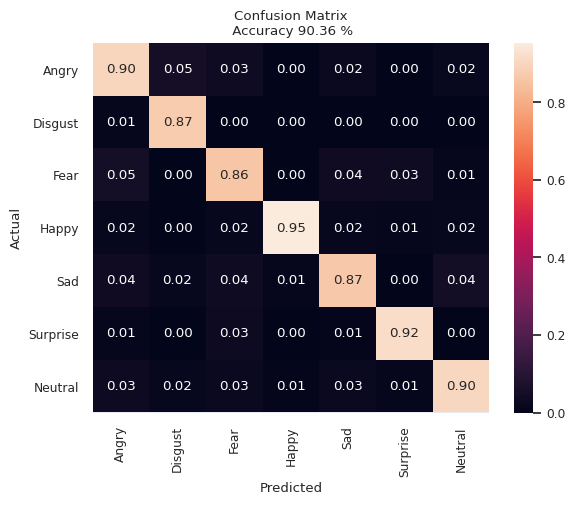

In [55]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred)

Batch 16

In [68]:
# set training parameter
batch_size = 16
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = (x_val, y_val)

In [69]:
efficient = build_model_efficient(lr=0.0001)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

model name    :  EfficientNetB0
learning rate :  1e-04


In [70]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB0_lr0001_Bath16' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [71]:
epochs = 128
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])


Epoch 1/128
3762/3762 [==============================] - ETA: 0s - loss: 1.5540 - accuracy: 0.4026
Epoch 1: val_accuracy improved from -inf to 0.49735, saving model to models/EfficientNetB0_lr0001_Bath16_20231126-095612.h5
3762/3762 [==============================] - 129s 32ms/step - loss: 1.5540 - accuracy: 0.4026 - val_loss: 1.3221 - val_accuracy: 0.4974
Epoch 2/128
3761/3762 [============================>.] - ETA: 0s - loss: 1.2688 - accuracy: 0.5201
Epoch 2: val_accuracy improved from 0.49735 to 0.56199, saving model to models/EfficientNetB0_lr0001_Bath16_20231126-095612.h5
3762/3762 [==============================] - 119s 32ms/step - loss: 1.2687 - accuracy: 0.5202 - val_loss: 1.1840 - val_accuracy: 0.5620
Epoch 3/128
3761/3762 [============================>.] - ETA: 0s - loss: 1.1608 - accuracy: 0.5609
Epoch 3: val_accuracy improved from 0.56199 to 0.59264, saving model to models/EfficientNetB0_lr0001_Bath16_20231126-095612.h5
3762/3762 [==============================] - 117s 31m

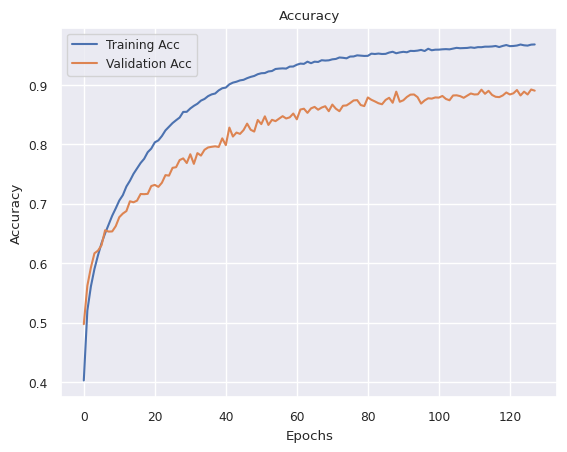

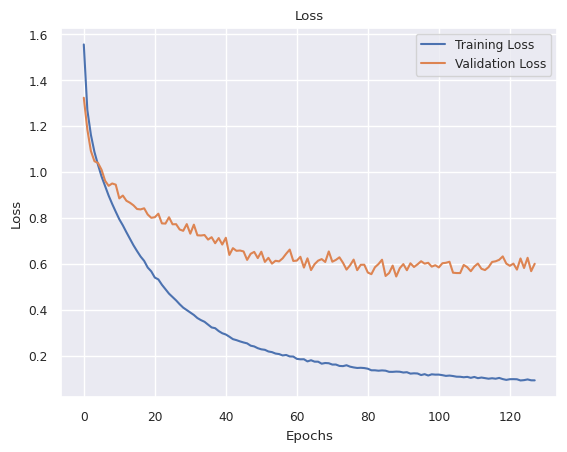

In [72]:
display_evaluation(hist.history)

113/113 [==============================] - 2s 8ms/step
Confusion Matrix:
[[419   6  24   5  24   2  11]
 [  0  53   0   0   1   0   1]
 [ 21   4 451   5  25  11  11]
 [  8   1   8 824   8  10  20]
 [ 14   2  16   7 528   0  27]
 [  3   0  15  13   2 380   3]
 [ 15   1  10  12  40   0 548]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.87      0.85      0.86       491
     Disgust       0.79      0.96      0.87        55
        Fear       0.86      0.85      0.86       528
       Happy       0.95      0.94      0.94       879
         Sad       0.84      0.89      0.86       594
    Surprise       0.94      0.91      0.93       416
     Neutral       0.88      0.88      0.88       626

    accuracy                           0.89      3589
   macro avg       0.88      0.90      0.89      3589
weighted avg       0.89      0.89      0.89      3589



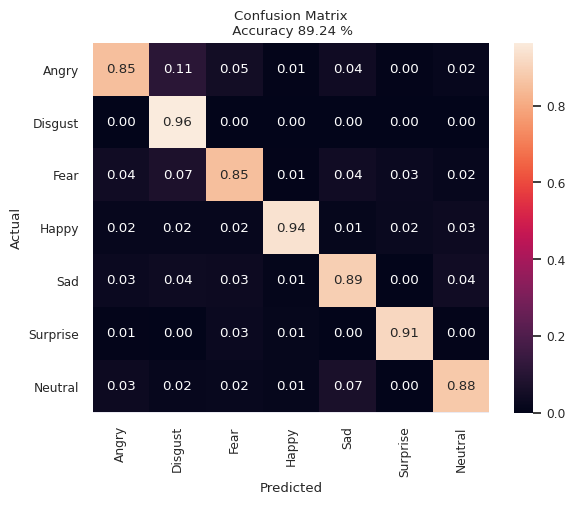

In [73]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred)

Batch 8

In [84]:
# set training parameter
batch_size = 8
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = (x_val, y_val)

In [85]:
efficient = build_model_efficient(lr=0.0001)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

model name    :  EfficientNetB0
learning rate :  1e-04


In [86]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB0_lr0001_Bath8' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [87]:
epochs = 64
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])


Epoch 1/64
7523/7523 [==============================] - ETA: 0s - loss: 1.5323 - accuracy: 0.4127
Epoch 1: val_accuracy improved from -inf to 0.49791, saving model to models/EfficientNetB0_lr0001_Bath8_20231126-152804.h5
7523/7523 [==============================] - 241s 31ms/step - loss: 1.5323 - accuracy: 0.4127 - val_loss: 1.3425 - val_accuracy: 0.4979
Epoch 2/64
7523/7523 [==============================] - ETA: 0s - loss: 1.2806 - accuracy: 0.5163
Epoch 2: val_accuracy improved from 0.49791 to 0.55921, saving model to models/EfficientNetB0_lr0001_Bath8_20231126-152804.h5
7523/7523 [==============================] - 233s 31ms/step - loss: 1.2806 - accuracy: 0.5163 - val_loss: 1.1717 - val_accuracy: 0.5592
Epoch 3/64
7522/7523 [============================>.] - ETA: 0s - loss: 1.1685 - accuracy: 0.5582
Epoch 3: val_accuracy improved from 0.55921 to 0.58568, saving model to models/EfficientNetB0_lr0001_Bath8_20231126-152804.h5
7523/7523 [==============================] - 233s 31ms/step

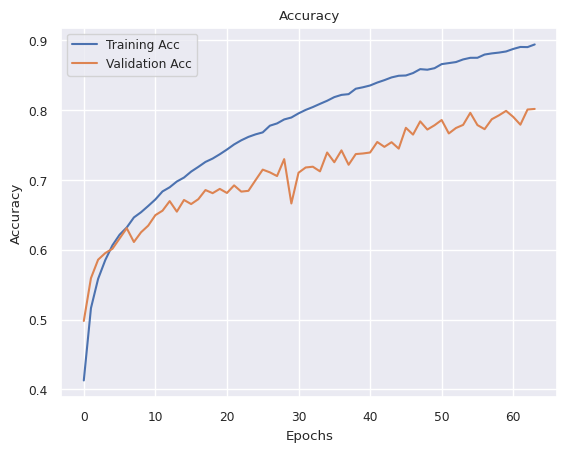

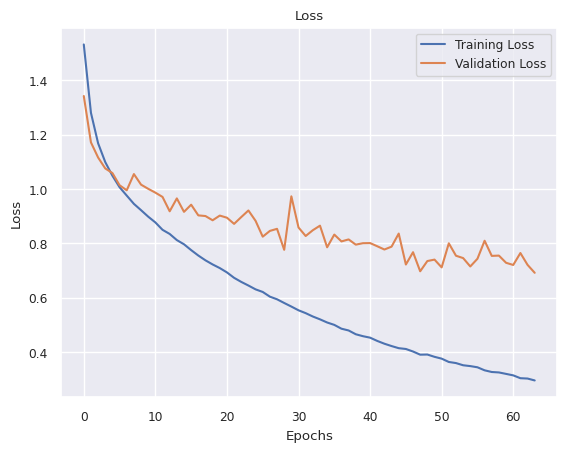

In [88]:
display_evaluation(hist.history)

113/113 [==============================] - 2s 8ms/step
Confusion Matrix:
[[373   8  30   3  40  15  22]
 [  1  52   0   0   1   1   0]
 [ 31   7 391   7  44  28  20]
 [ 10   0  11 790  18  23  27]
 [ 22   7  43  15 458  12  37]
 [  4   2  19   8   7 373   3]
 [ 20   5  33  14  59  16 479]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.81      0.76      0.78       491
     Disgust       0.64      0.95      0.76        55
        Fear       0.74      0.74      0.74       528
       Happy       0.94      0.90      0.92       879
         Sad       0.73      0.77      0.75       594
    Surprise       0.80      0.90      0.84       416
     Neutral       0.81      0.77      0.79       626

    accuracy                           0.81      3589
   macro avg       0.78      0.83      0.80      3589
weighted avg       0.82      0.81      0.81      3589



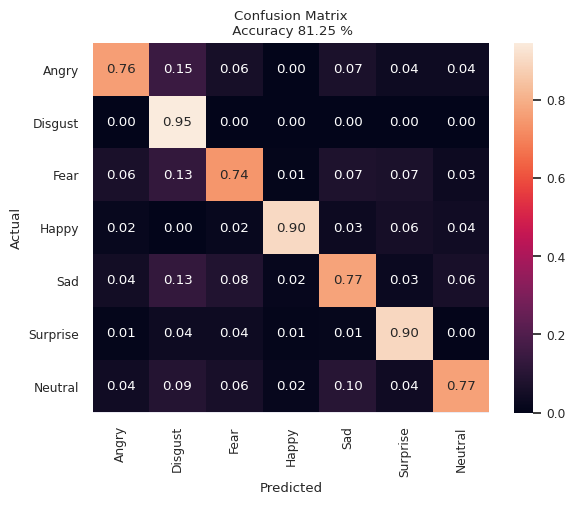

In [89]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred)

Batch 128

In [78]:
# set training parameter
batch_size = 128
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = (x_val, y_val)

In [79]:
efficient = build_model_efficient(lr=0.0001)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

model name    :  EfficientNetB0
learning rate :  1e-04


In [80]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB0_lr0001_Bath128' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [81]:
epochs = 128
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])


Epoch 1/128
471/471 [==============================] - ETA: 0s - loss: 1.7036 - accuracy: 0.3401
Epoch 1: val_accuracy improved from -inf to 0.40150, saving model to models/EfficientNetB0_lr0001_Bath128_20231126-141622.h5
471/471 [==============================] - 41s 74ms/step - loss: 1.7036 - accuracy: 0.3401 - val_loss: 1.5570 - val_accuracy: 0.4015
Epoch 2/128
471/471 [==============================] - ETA: 0s - loss: 1.4021 - accuracy: 0.4678
Epoch 2: val_accuracy improved from 0.40150 to 0.49401, saving model to models/EfficientNetB0_lr0001_Bath128_20231126-141622.h5
471/471 [==============================] - 34s 71ms/step - loss: 1.4021 - accuracy: 0.4678 - val_loss: 1.3489 - val_accuracy: 0.4940
Epoch 3/128
471/471 [==============================] - ETA: 0s - loss: 1.2694 - accuracy: 0.5198
Epoch 3: val_accuracy improved from 0.49401 to 0.52967, saving model to models/EfficientNetB0_lr0001_Bath128_20231126-141622.h5
471/471 [==============================] - 34s 72ms/step - los

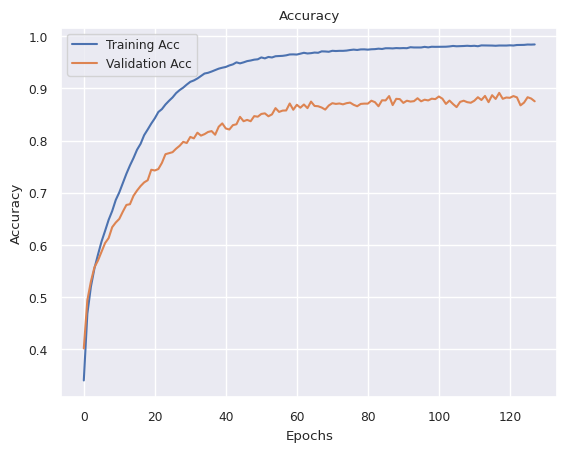

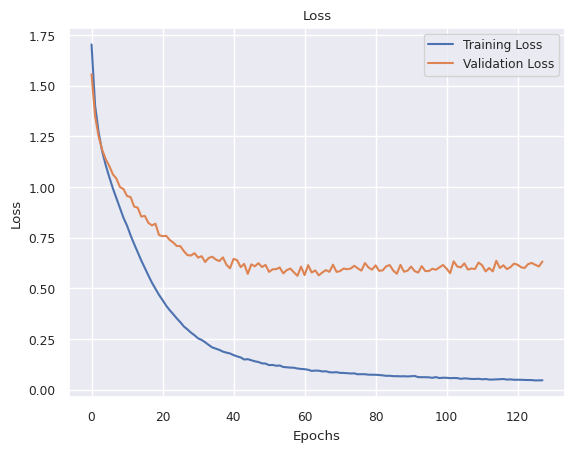

In [82]:
display_evaluation(hist.history)

113/113 [==============================] - 3s 8ms/step
Confusion Matrix:
[[430   3  17   3  17   1  20]
 [  7  47   1   0   0   0   0]
 [ 27   1 445   2  24  10  19]
 [  8   0   7 823   7  10  24]
 [ 20   1  19  11 509   2  32]
 [  7   0  15   3   3 384   4]
 [ 17   0  10  10  16   4 569]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.83      0.88      0.85       491
     Disgust       0.90      0.85      0.88        55
        Fear       0.87      0.84      0.85       528
       Happy       0.97      0.94      0.95       879
         Sad       0.88      0.86      0.87       594
    Surprise       0.93      0.92      0.93       416
     Neutral       0.85      0.91      0.88       626

    accuracy                           0.89      3589
   macro avg       0.89      0.89      0.89      3589
weighted avg       0.89      0.89      0.89      3589



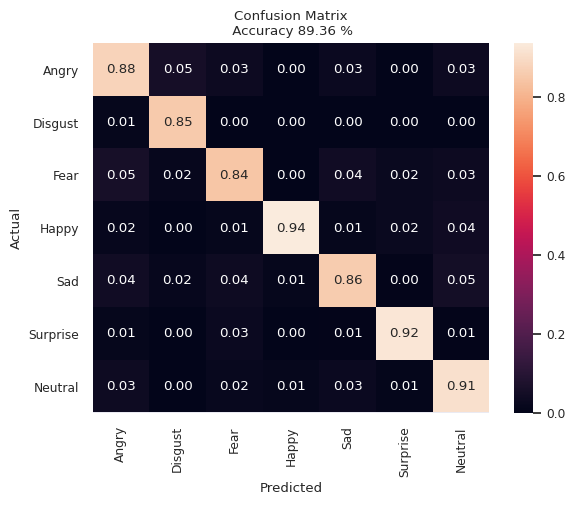

In [83]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred)

# EfficientNet 224

## Load Data

In [9]:
with open('pkl/rgb_224.pkl', 'rb') as f:
    df = pickle.load(f) # load pickle data
df.head()

Unnamed: 0  emotion     Usage  \
0           0        5  Training   
1           1        5  Training   
2           2        5  Training   
3           3        5  Training   
4           4        5  Training   

                                              pixels  \
0  247 247 213 212 173 125 87 79 72 71 82 111 144...   
1  33 29 28 34 39 42 42 34 36 45 42 54 56 55 63 6...   
2  226 229 226 228 222 223 224 222 222 223 230 23...   
3  58 80 94 115 159 224 233 231 234 238 231 224 2...   
4  85 80 86 86 82 73 68 57 66 77 68 73 71 79 76 8...   

                                             rgb_224  
0  [[[247, 247, 247], [247, 247, 247], [247, 247,...  
1  [[[33, 33, 33], [33, 33, 33], [33, 33, 33], [3...  
2  [[[226, 226, 226], [226, 226, 226], [226, 226,...  
3  [[[58, 58, 58], [58, 58, 58], [58, 58, 58], [5...  
4  [[[85, 85, 85], [85, 85, 85], [85, 85, 85], [8...

## Preprocessing

In [10]:
# extract Feature
x_train, x_val, x_test, y_train, y_val, y_test = select_feature(df, 'rgb_224')


jumlah data train : 
60184.0
jumlah data validation : 
3589.0
jumlah data test : 
3589.0


In [11]:
# image Augmentation
datagen = ImageDataGenerator(
    rotation_range = 20,
    shear_range = 0.3,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [12]:
# set training parameter
batch_size = 64
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = (x_val, y_val)

## EfficientNetB0

In [12]:
def build_model_efficientB0(lr=0.001):
    #model EfficientNetB0
    efficient = EfficientNetB0(weights='imagenet', 
                               include_top=False, 
                               input_shape=(224, 224, 3))
    efficient.trainable = True

    x = efficient.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(7, activation='softmax')(x)

    efficient = Model(inputs=efficient.input, 
                      outputs=output, 
                      name="EfficientNetB0")
    
    efficient.compile(optimizer=Adam(learning_rate=lr), 
                      loss='categorical_crossentropy', metrics=['accuracy'])

    return efficient

### Lr 0.001

In [16]:
efficient = build_model_efficientB0(lr=0.001)

print('model name    : ', efficient.name)
print('learning rate : ', K.get_value(efficient.optimizer.lr))

2023-11-28 08:18:38.109851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 08:18:38.645130: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38418 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:90:00.0, compute capability: 8.0


model name    :  EfficientNetB0
learning rate :  0.001


In [17]:
# start 
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'EfficientNetB0_lr001_224' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [18]:
#plan epoch 32 est 4.5 jam

epochs = 2
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/2


2023-11-28 08:19:02.170953: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-11-28 08:19:03.653018: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


941/941 [==============================] - ETA: 0s - loss: 1.0936 - accuracy: 0.5854
Epoch 1: val_accuracy improved from -inf to 0.61995, saving model to models/EfficientNetB0_lr001_224_20231128-081850.h5
941/941 [==============================] - 500s 522ms/step - loss: 1.0936 - accuracy: 0.5854 - val_loss: 1.0168 - val_accuracy: 0.6199
Epoch 2/2
941/941 [==============================] - ETA: 0s - loss: 0.8965 - accuracy: 0.6639
Epoch 2: val_accuracy improved from 0.61995 to 0.66091, saving model to models/EfficientNetB0_lr001_224_20231128-081850.h5
941/941 [==============================] - 482s 512ms/step - loss: 0.8965 - accuracy: 0.6639 - val_loss: 0.9208 - val_accuracy: 0.6609

|===========General==============|
  Training Process --> 16.37 menit

|=========Best Model============|
Monitor : val_accuracy
Epoch : 2
val_accuracy : 66.09 %
Time : 16.35 menit


In [21]:
#plan epoch 

epochs = 2
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/2
941/941 [==============================] - ETA: 0s - loss: 0.8165 - accuracy: 0.6964
Epoch 1: val_accuracy improved from 0.66091 to 0.68153, saving model to models/EfficientNetB0_lr001_224_20231128-081850.h5
941/941 [==============================] - 481s 510ms/step - loss: 0.8165 - accuracy: 0.6964 - val_loss: 0.8605 - val_accuracy: 0.6815
Epoch 2/2
941/941 [==============================] - ETA: 0s - loss: 0.7458 - accuracy: 0.7233
Epoch 2: val_accuracy improved from 0.68153 to 0.68376, saving model to models/EfficientNetB0_lr001_224_20231128-081850.h5
941/941 [==============================] - 480s 510ms/step - loss: 0.7458 - accuracy: 0.7233 - val_loss: 0.8535 - val_accuracy: 0.6838

|===========General==============|
  Training Process --> 16.02 menit

|=========Best Model============|
Monitor : val_accuracy
Epoch : 2
val_accuracy : 68.38 %
Time : 16.00 menit


In [22]:
#plan epoch 

epochs = 6
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/6
941/941 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.7464
Epoch 1: val_accuracy improved from 0.68376 to 0.69100, saving model to models/EfficientNetB0_lr001_224_20231128-081850.h5
941/941 [==============================] - 484s 514ms/step - loss: 0.6822 - accuracy: 0.7464 - val_loss: 0.8515 - val_accuracy: 0.6910
Epoch 2/6
941/941 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.7709
Epoch 2: val_accuracy improved from 0.69100 to 0.72722, saving model to models/EfficientNetB0_lr001_224_20231128-081850.h5
941/941 [==============================] - 482s 512ms/step - loss: 0.6216 - accuracy: 0.7709 - val_loss: 0.7573 - val_accuracy: 0.7272
Epoch 3/6
941/941 [==============================] - ETA: 0s - loss: 0.5535 - accuracy: 0.7966
Epoch 3: val_accuracy improved from 0.72722 to 0.74673, saving model to models/EfficientNetB0_lr001_224_20231128-081850.h5
941/941 [==============================] - 484s 514ms/step - loss: 0.5535 - 

In [23]:
#plan epoch 

epochs = 4
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/4
941/941 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 0.8733
Epoch 1: val_accuracy did not improve from 0.79772
941/941 [==============================] - 484s 514ms/step - loss: 0.3525 - accuracy: 0.8733 - val_loss: 0.6571 - val_accuracy: 0.7905
Epoch 2/4
941/941 [==============================] - ETA: 0s - loss: 0.3205 - accuracy: 0.8845
Epoch 2: val_accuracy improved from 0.79772 to 0.82084, saving model to models/EfficientNetB0_lr001_224_20231128-081850.h5
941/941 [==============================] - 482s 512ms/step - loss: 0.3205 - accuracy: 0.8845 - val_loss: 0.6025 - val_accuracy: 0.8208
Epoch 3/4
941/941 [==============================] - ETA: 0s - loss: 0.2933 - accuracy: 0.8946
Epoch 3: val_accuracy improved from 0.82084 to 0.83895, saving model to models/EfficientNetB0_lr001_224_20231128-081850.h5
941/941 [==============================] - 487s 517ms/step - loss: 0.2933 - accuracy: 0.8946 - val_loss: 0.5378 - val_accuracy: 0.8390
Epoch 4/4
941

In [ ]:
#plan epoch 

epochs = 4
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/4
941/941 [==============================] - ETA: 0s - loss: 0.2487 - accuracy: 0.9109
Epoch 1: val_accuracy improved from 0.83923 to 0.85065, saving model to models/EfficientNetB0_lr001_224_20231128-081850.h5
941/941 [==============================] - 482s 512ms/step - loss: 0.2487 - accuracy: 0.9109 - val_loss: 0.5404 - val_accuracy: 0.8507
Epoch 2/4
941/941 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.9176
Epoch 2: val_accuracy did not improve from 0.85065
941/941 [==============================] - 480s 510ms/step - loss: 0.2310 - accuracy: 0.9176 - val_loss: 0.5890 - val_accuracy: 0.8359
Epoch 3/4
941/941 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.9236
Epoch 3: val_accuracy did not improve from 0.85065
941/941 [==============================] - 485s 515ms/step - loss: 0.2150 - accuracy: 0.9236 - val_loss: 0.5830 - val_accuracy: 0.8468
Epoch 4/4
941/941 [==============================] - ETA: 0s - loss: 0.2049 - accurac

In [28]:
#plan epoch 

epochs = 4
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/4
941/941 [==============================] - ETA: 0s - loss: 0.1906 - accuracy: 0.9327
Epoch 1: val_accuracy improved from 0.86626 to 0.86765, saving model to models/EfficientNetB0_lr001_224_20231128-081850.h5
941/941 [==============================] - 492s 523ms/step - loss: 0.1906 - accuracy: 0.9327 - val_loss: 0.5323 - val_accuracy: 0.8677
Epoch 2/4
941/941 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9372
Epoch 2: val_accuracy did not improve from 0.86765
941/941 [==============================] - 488s 519ms/step - loss: 0.1802 - accuracy: 0.9372 - val_loss: 0.5628 - val_accuracy: 0.8629
Epoch 3/4
941/941 [==============================] - ETA: 0s - loss: 0.1768 - accuracy: 0.9376
Epoch 3: val_accuracy did not improve from 0.86765
941/941 [==============================] - 486s 516ms/step - loss: 0.1768 - accuracy: 0.9376 - val_loss: 0.5294 - val_accuracy: 0.8579
Epoch 4/4
941/941 [==============================] - ETA: 0s - loss: 0.1706 - accurac

In [31]:
#plan epoch 

epochs = 4
hist = efficient.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])



Epoch 1/4
941/941 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.9425
Epoch 1: val_accuracy improved from 0.87573 to 0.88019, saving model to models/EfficientNetB0_lr001_224_20231128-081850.h5
941/941 [==============================] - 486s 516ms/step - loss: 0.1622 - accuracy: 0.9425 - val_loss: 0.4868 - val_accuracy: 0.8802
Epoch 2/4
941/941 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.9468
Epoch 2: val_accuracy did not improve from 0.88019
941/941 [==============================] - 487s 517ms/step - loss: 0.1486 - accuracy: 0.9468 - val_loss: 0.5199 - val_accuracy: 0.8760
Epoch 3/4
941/941 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9460
Epoch 3: val_accuracy did not improve from 0.88019
941/941 [==============================] - 488s 518ms/step - loss: 0.1502 - accuracy: 0.9460 - val_loss: 0.6095 - val_accuracy: 0.8629
Epoch 4/4
941/941 [==============================] - ETA: 0s - loss: 0.1449 - accurac

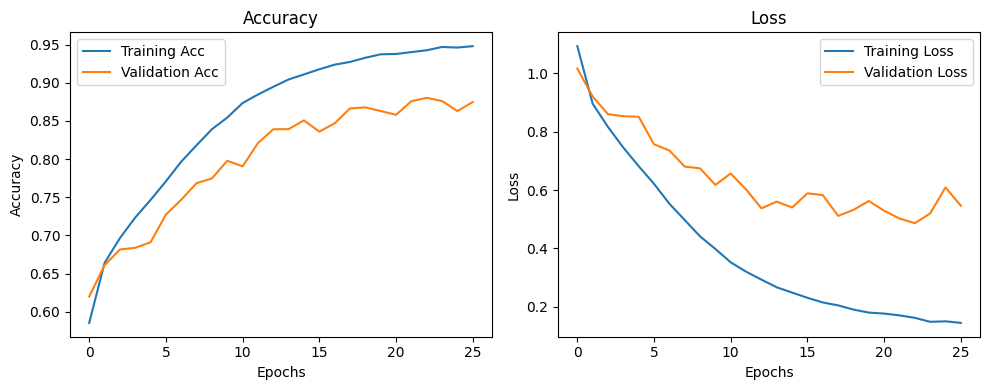

In [12]:
sns.reset_defaults()
model_name = 'EfficientNetB0_lr001_224_20231128-081850'
plot = pd.read_csv(f'history_csv/{model_name}.csv')
display_evaluation_v2(plot, 'plot/' + model_name)

In [13]:
model_name = 'EfficientNetB0_lr001_224_20231128-081850'
efficient = load_model(f'models/{model_name}.h5')

2023-12-08 15:51:47.851201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 15:51:48.320970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:90:00.0, compute capability: 8.0


2023-12-03 23:43:32.710283: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


 14/113 [==>...........................] - ETA: 1s

2023-12-03 23:43:34.143600: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


113/113 [==============================] - 3s 14ms/step - loss: 0.3994 - accuracy: 0.8963
test loss : 0.3994433581829071
test acc  : 0.8963499665260315
Confusion Matrix:
[[433   3  15   3  26   1  10]
 [  6  49   0   0   0   0   0]
 [ 29   1 421   4  41  17  15]
 [  7   0   4 843   8   9   8]
 [ 18   0  17   6 518   0  35]
 [  1   0  10   7   5 390   3]
 [ 11   2   9  12  26   3 563]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.86      0.88      0.87       491
     Disgust       0.89      0.89      0.89        55
        Fear       0.88      0.80      0.84       528
       Happy       0.96      0.96      0.96       879
         Sad       0.83      0.87      0.85       594
    Surprise       0.93      0.94      0.93       416
     Neutral       0.89      0.90      0.89       626

    accuracy                           0.90      3589
   macro avg       0.89      0.89      0.89      3589
weighted avg       0.90      0.90      0.90   

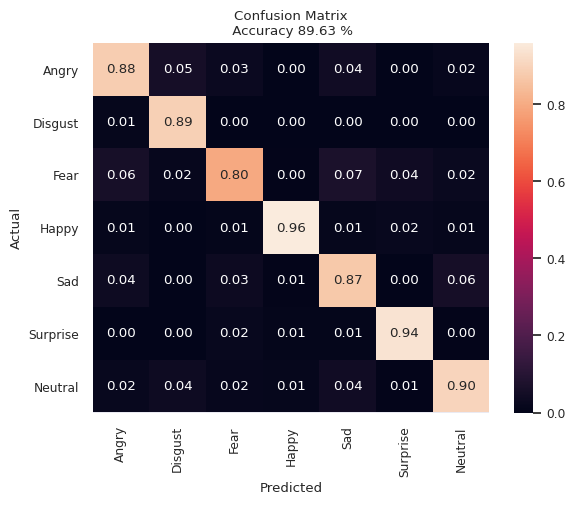

In [15]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred, save=True, name_file=f'plot/conf_{model_name}')

In [19]:
y_pred, y_true = get_predict(efficient, x_test, y_test)

show_report(y_true, y_pred,  digits=4)

113/113 [==============================] - 2s 14ms/step - loss: 0.3994 - accuracy: 0.8963
test loss : 0.3994433581829071
test acc  : 0.8963499665260315
Confusion Matrix:
[[433   3  15   3  26   1  10]
 [  6  49   0   0   0   0   0]
 [ 29   1 421   4  41  17  15]
 [  7   0   4 843   8   9   8]
 [ 18   0  17   6 518   0  35]
 [  1   0  10   7   5 390   3]
 [ 11   2   9  12  26   3 563]]

Classification Report:
              precision    recall  f1-score   support

       Angry     0.8574    0.8819    0.8695       491
     Disgust     0.8909    0.8909    0.8909        55
        Fear     0.8845    0.7973    0.8386       528
       Happy     0.9634    0.9590    0.9612       879
         Sad     0.8301    0.8721    0.8506       594
    Surprise     0.9286    0.9375    0.9330       416
     Neutral     0.8880    0.8994    0.8937       626

    accuracy                         0.8963      3589
   macro avg     0.8918    0.8912    0.8911      3589
weighted avg     0.8969    0.8963    0.8962   

In [18]:
y_pred, y_true = get_predict(efficient, x_val, y_val)

show_report(y_true, y_pred)

113/113 [==============================] - 2s 14ms/step - loss: 0.4868 - accuracy: 0.8802
test loss : 0.48676034808158875
test acc  : 0.8801894783973694
Confusion Matrix:
[[391   4  19   7  32   4  10]
 [  1  51   1   1   1   0   1]
 [ 21   1 387   8  42  21  16]
 [  6   0   4 848   8   8  21]
 [ 25   3  21   9 565   3  27]
 [  2   0   8   4   3 391   7]
 [ 14   0   9  19  37   2 526]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.85      0.84      0.84       467
     Disgust       0.86      0.91      0.89        56
        Fear       0.86      0.78      0.82       496
       Happy       0.95      0.95      0.95       895
         Sad       0.82      0.87      0.84       653
    Surprise       0.91      0.94      0.93       415
     Neutral       0.87      0.87      0.87       607

    accuracy                           0.88      3589
   macro avg       0.87      0.88      0.88      3589
weighted avg       0.88      0.88      0.88  

---


# LightCNN
input (224,224,1) - gray_224
 
 Augmented Data :

|type| value |
|---|---|
|rotation_range | 20 |
|shear_range | 30 |
|zoom_range | 20 |
|horizontal_flip | True|


Result :
| lr | Val Acc | Acc| Augmented | Best Time | Epoch | id |
|--- |---|---|---|---|---|---|
|0.001| 73.70 | 83.14 | Yes | 639,79m | 62 | |

## Load Data

In [22]:
with open('pkl/gray_224.pkl', 'rb') as f:
    df = pickle.load(f) # load pickle data
df.head()

Unnamed: 0  emotion     Usage  \
0           0        5  Training   
1           1        5  Training   
2           2        5  Training   
3           3        5  Training   
4           4        5  Training   

                                              pixels  \
0  247 247 213 212 173 125 87 79 72 71 82 111 144...   
1  33 29 28 34 39 42 42 34 36 45 42 54 56 55 63 6...   
2  226 229 226 228 222 223 224 222 222 223 230 23...   
3  58 80 94 115 159 224 233 231 234 238 231 224 2...   
4  85 80 86 86 82 73 68 57 66 77 68 73 71 79 76 8...   

                                            gray_224  
0  [[247, 247, 247, 247, 247, 247, 247, 247, 247,...  
1  [[33, 33, 33, 33, 33, 29, 29, 29, 29, 28, 28, ...  
2  [[226, 226, 226, 226, 226, 229, 229, 229, 229,...  
3  [[58, 58, 58, 58, 58, 80, 80, 80, 80, 94, 94, ...  
4  [[85, 85, 85, 85, 85, 80, 80, 80, 80, 86, 86, ...

## Preprocessing

In [23]:
# extract Feature
x_train, x_val, x_test, y_train, y_val, y_test = select_feature(df, 'gray_224')
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

jumlah data train : 
60184.0
jumlah data validation : 
3589.0
jumlah data test : 
3589.0


In [24]:
# image Augmentation
datagen = ImageDataGenerator(
    rotation_range = 20,
    shear_range = 0.3,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [25]:
# set training parameter
batch_size = 64
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = (x_val, y_val)

## Lr 0.001

In [38]:
# architecture model
#### v3 : last 2 padding valid
def Deptwise_Separable_Residual_Conv2D(input_net, filters=16):
  x = SeparableConv2D(filters, (1,1), activation='relu', padding='same')(input_net)
  x = BatchNormalization()(x)
  x = SeparableConv2D(filters, (3,3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = SeparableConv2D(filters, (1,1), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

  side = Conv2D(filters=filters, kernel_size=(1, 1), activation='relu', strides=(2, 2), padding='valid')(input_net)
  side = BatchNormalization()(side)

  output_net = Add()([x, side])

  return output_net

# v3 : last 2 padding valid
input_layer = Input(shape=(224, 224, 1))

b1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
b1 = BatchNormalization()(b1)

b1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(b1)
b1 = BatchNormalization()(b1)

sep1 = Deptwise_Separable_Residual_Conv2D(b1, 16)
sep2 = Deptwise_Separable_Residual_Conv2D(sep1, 32)
sep3 = Deptwise_Separable_Residual_Conv2D(sep2, 64)
sep4 = Deptwise_Separable_Residual_Conv2D(sep3, 128)
sep5 = Deptwise_Separable_Residual_Conv2D(sep4, 256)
sep6 = Deptwise_Separable_Residual_Conv2D(sep5, 512)

x = MaxPooling2D(pool_size=(1, 1), strides=(1, 1), padding='valid')(sep6) # num_class layer
x = Conv2D(4, (2 , 2), activation='relu')(x)
x = GlobalAveragePooling2D()(x) #GAP2d layer
output_layer = Dense(7, activation='softmax')(x)

lightCNN = Model(inputs=input_layer, outputs=output_layer, name='LightCNN')
lightCNN.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

lightCNN.summary()
# plot_model(model, show_shapes=True, to_file='residual_module.png')

Model: "LightCNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 224, 224, 8)  80          ['input_5[0][0]']                
                                                                                                  
 batch_normalization_78 (BatchN  (None, 224, 224, 8)  32         ['conv2d_27[0][0]']              
 ormalization)                                                                                    
                                                                                           

In [39]:
K.set_value(lightCNN.optimizer.learning_rate, 0.001)

print('model name    : ', lightCNN.name)
print('learning rate : ', K.get_value(lightCNN.optimizer.lr))

model name    :  LightCNN
learning rate :  0.001


In [40]:
executed_time = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = 'LightCNN_lr001' + '_' + executed_time

checkpoint_callback = ModelCheckpoint(filepath='models/' + model_name + '.h5',
                                      save_best_only=True,
                                      monitor= 'val_accuracy',
                                      verbose=1)

csv_name = 'history_csv/' + model_name + '.csv'
CSVLogger = keras.callbacks.CSVLogger(csv_name, 
                                      separator=',', 
                                      append=True )

log_dir = f'logs/{model_name}'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

best_timer_callback = BestModelCallback(monitor= 'val_accuracy')

In [41]:
epochs = 12

hist = lightCNN.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])

Epoch 1/12
941/941 [==============================] - ETA: 0s - loss: 1.8284 - accuracy: 0.2620
Epoch 1: val_accuracy improved from -inf to 0.28058, saving model to models/LightCNN_lr001_20231119-012120.h5
941/941 [==============================] - 625s 662ms/step - loss: 1.8284 - accuracy: 0.2620 - val_loss: 1.7887 - val_accuracy: 0.2806
Epoch 2/12
941/941 [==============================] - ETA: 0s - loss: 1.6682 - accuracy: 0.3404
Epoch 2: val_accuracy improved from 0.28058 to 0.39649, saving model to models/LightCNN_lr001_20231119-012120.h5
941/941 [==============================] - 621s 660ms/step - loss: 1.6682 - accuracy: 0.3404 - val_loss: 1.5386 - val_accuracy: 0.3965
Epoch 3/12
941/941 [==============================] - ETA: 0s - loss: 1.4861 - accuracy: 0.4224
Epoch 3: val_accuracy did not improve from 0.39649
941/941 [==============================] - 623s 662ms/step - loss: 1.4861 - accuracy: 0.4224 - val_loss: 1.6555 - val_accuracy: 0.3725
Epoch 4/12
941/941 [=============

In [42]:
epochs = 16

hist = lightCNN.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])

Epoch 1/16
941/941 [==============================] - ETA: 0s - loss: 1.0228 - accuracy: 0.6125
Epoch 1: val_accuracy did not improve from 0.57453
941/941 [==============================] - 619s 658ms/step - loss: 1.0228 - accuracy: 0.6125 - val_loss: 1.3278 - val_accuracy: 0.5057
Epoch 2/16
941/941 [==============================] - ETA: 0s - loss: 1.0051 - accuracy: 0.6198
Epoch 2: val_accuracy improved from 0.57453 to 0.57509, saving model to models/LightCNN_lr001_20231119-012120.h5
941/941 [==============================] - 628s 667ms/step - loss: 1.0051 - accuracy: 0.6198 - val_loss: 1.1327 - val_accuracy: 0.5751
Epoch 3/16
941/941 [==============================] - ETA: 0s - loss: 0.9897 - accuracy: 0.6263
Epoch 3: val_accuracy did not improve from 0.57509
941/941 [==============================] - 613s 652ms/step - loss: 0.9897 - accuracy: 0.6263 - val_loss: 1.5204 - val_accuracy: 0.4213
Epoch 4/16
941/941 [==============================] - ETA: 0s - loss: 0.9717 - accuracy: 0.6

In [43]:
epochs = 16

hist = lightCNN.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])

Epoch 1/16
941/941 [==============================] - ETA: 0s - loss: 0.7978 - accuracy: 0.7027
Epoch 1: val_accuracy did not improve from 0.65729
941/941 [==============================] - 613s 652ms/step - loss: 0.7978 - accuracy: 0.7027 - val_loss: 1.0478 - val_accuracy: 0.6202
Epoch 2/16
941/941 [==============================] - ETA: 0s - loss: 0.7825 - accuracy: 0.7108
Epoch 2: val_accuracy did not improve from 0.65729
941/941 [==============================] - 612s 650ms/step - loss: 0.7825 - accuracy: 0.7108 - val_loss: 1.0482 - val_accuracy: 0.6108
Epoch 3/16
941/941 [==============================] - ETA: 0s - loss: 0.7682 - accuracy: 0.7152
Epoch 3: val_accuracy did not improve from 0.65729
941/941 [==============================] - 615s 653ms/step - loss: 0.7682 - accuracy: 0.7152 - val_loss: 1.2197 - val_accuracy: 0.5492
Epoch 4/16
941/941 [==============================] - ETA: 0s - loss: 0.7587 - accuracy: 0.7213
Epoch 4: val_accuracy did not improve from 0.65729
941/941

In [44]:
epochs = 10

hist = lightCNN.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])

Epoch 1/10
941/941 [==============================] - ETA: 0s - loss: 0.6210 - accuracy: 0.7721
Epoch 1: val_accuracy did not improve from 0.68794
941/941 [==============================] - 624s 663ms/step - loss: 0.6210 - accuracy: 0.7721 - val_loss: 1.4627 - val_accuracy: 0.5088
Epoch 2/10
941/941 [==============================] - ETA: 0s - loss: 0.6128 - accuracy: 0.7758
Epoch 2: val_accuracy did not improve from 0.68794
941/941 [==============================] - 623s 662ms/step - loss: 0.6128 - accuracy: 0.7758 - val_loss: 0.9854 - val_accuracy: 0.6626
Epoch 3/10
941/941 [==============================] - ETA: 0s - loss: 0.6005 - accuracy: 0.7804
Epoch 3: val_accuracy did not improve from 0.68794
941/941 [==============================] - 624s 663ms/step - loss: 0.6005 - accuracy: 0.7804 - val_loss: 1.3046 - val_accuracy: 0.5720
Epoch 4/10
941/941 [==============================] - ETA: 0s - loss: 0.5896 - accuracy: 0.7843
Epoch 4: val_accuracy did not improve from 0.68794
941/941

In [52]:
epochs = 10

hist = lightCNN.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=[checkpoint_callback, CSVLogger, best_timer_callback, tensorboard_callback])

Epoch 1/10
941/941 [==============================] - ETA: 0s - loss: 0.5286 - accuracy: 0.8093
Epoch 1: val_accuracy did not improve from 0.72416
941/941 [==============================] - 623s 662ms/step - loss: 0.5286 - accuracy: 0.8093 - val_loss: 0.9326 - val_accuracy: 0.6927
Epoch 2/10
941/941 [==============================] - ETA: 0s - loss: 0.5241 - accuracy: 0.8098
Epoch 2: val_accuracy improved from 0.72416 to 0.73224, saving model to models/LightCNN_lr001_20231119-012120.h5
941/941 [==============================] - 622s 660ms/step - loss: 0.5241 - accuracy: 0.8098 - val_loss: 0.7921 - val_accuracy: 0.7322
Epoch 3/10
941/941 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.8129
Epoch 3: val_accuracy did not improve from 0.73224
941/941 [==============================] - 620s 659ms/step - loss: 0.5175 - accuracy: 0.8129 - val_loss: 0.8086 - val_accuracy: 0.7253
Epoch 4/10
941/941 [==============================] - ETA: 0s - loss: 0.5066 - accuracy: 0.8

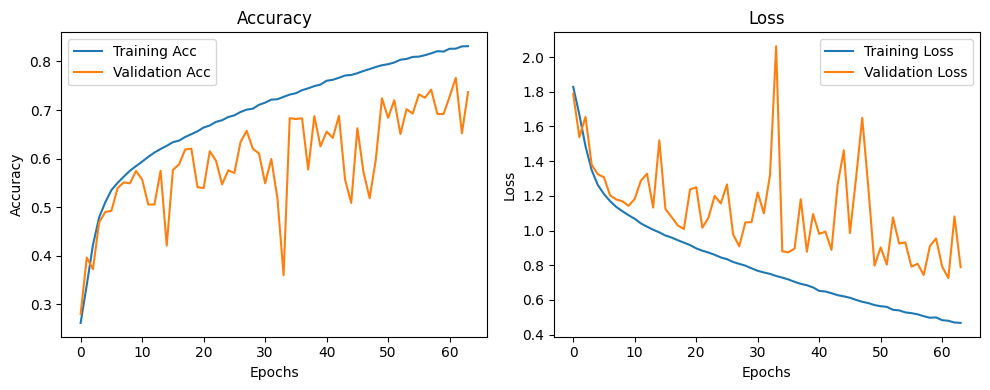

In [26]:
sns.reset_defaults()
model_name = 'LightCNN_lr001_20231119-012120'
plot = pd.read_csv(f'history_csv/{model_name}.csv')
display_evaluation_v2(plot, 'plot/' + model_name)

In [29]:
model_name = 'LightCNN_lr001_20231119-012120'
lightCNN = load_model(f'models/{model_name}.h5')

113/113 [==============================] - 1s 11ms/step - loss: 0.6535 - accuracy: 0.7785
test loss : 0.653501570224762
test acc  : 0.7784898281097412
Confusion Matrix:
[[347   7  48  10  51   3  25]
 [ 14  36   2   0   0   0   3]
 [ 47   5 342  15  72  20  27]
 [ 16   0   8 808  11   9  27]
 [ 34   0  68  14 409   0  69]
 [  6   0  36  14   3 347  10]
 [ 15   2  25  17  59   3 505]]

Classification Report:
              precision    recall  f1-score   support

       Angry       0.72      0.71      0.72       491
     Disgust       0.72      0.65      0.69        55
        Fear       0.65      0.65      0.65       528
       Happy       0.92      0.92      0.92       879
         Sad       0.68      0.69      0.68       594
    Surprise       0.91      0.83      0.87       416
     Neutral       0.76      0.81      0.78       626

    accuracy                           0.78      3589
   macro avg       0.76      0.75      0.76      3589
weighted avg       0.78      0.78      0.78    

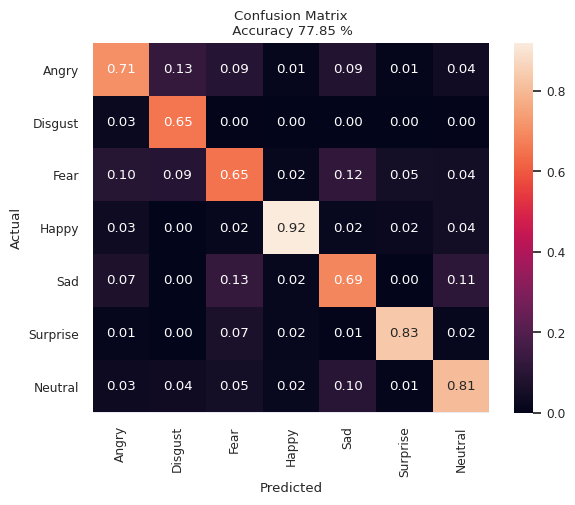

In [99]:
y_pred, y_true = get_predict(lightCNN, x_test, y_test)

show_report(y_true, y_pred)
display_confusion_mtx(y_true, y_pred, save=True, name_file=f'plot/conf_{model_name}')

# Speed Testing

1) lightCNN
2) best of EfficientNet 48x48
3) best of EfficientNet 224x224

| Model | Time | Input | Id |
| --- | --- | --- | --- |
| LightCNN | - | 224x224 Grayscale | LightCNN_lr001_20231119-012120 |
| EfficientNetB0 | - | 48x48 RGB | EfficientNetB0_lr0001_20231120-012401 |
| EfficientNetB0 | - | 224x224 RGB| EfficientNetB0_lr001_224_20231128-081850 |


## Function

In [17]:
def cvt_rgb48(image):
    
    return np.stack([image] * 3, axis=-1)

In [18]:
def resized_gray(image, target_size):
    # Convert to PIL Image
    pil_image = Image.fromarray(image)

    # Resize image with aspect ratio preservation
    pil_resized = pil_image.resize((target_size, target_size), Image.BOX)

    # Convert back to NumPy array
    resized_image = np.array(pil_resized)

    return resized_image


## LightCNN

In [73]:
model_name = 'LightCNN_lr001_20231119-012120'
lightCNN = load_model(f'models/{model_name}.h5')

(48, 48)


(1, 224, 224)

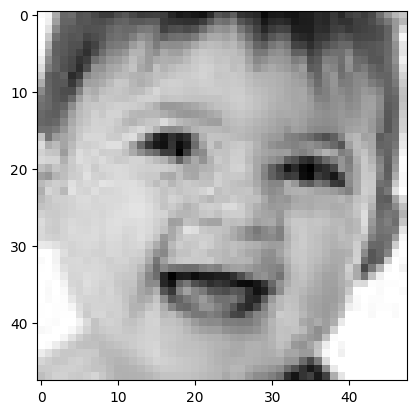

In [74]:
img = plt.imread('img/PrivateTest_32663.jpg')
plt.imshow(img, cmap='gray')
print(img.shape)
img = resized_gray(img, 224)
img = np.expand_dims(img, axis=0)
img.shape

In [75]:
CLASS = ['Angry','Disgust','Fear','Happy','Sad', 'Surprise', 'Neutral'] 

In [82]:
start = time.time()
pred = lightCNN.predict(img)
elapsed = time.time() - start

pred_label = CLASS[np.argmax(pred)]

print(f'=====Time Process =====')
print(f' LightCNN 224x224')
print(f'=======================')
print(f' Time     : {elapsed: 0.5f} s')
print(f' Ekspresi : {pred_label}')

1/1 [==============================] - 0s 36ms/step
=====Time Process =====
 LightCNN 224x224
 Time     :  0.07216 s
 Ekspresi : Happy


## EfficientNet 48x48

### Lr 0.0001

In [83]:
model_name = 'EfficientNetB0_lr0001_20231120-012401'
efficient = load_model(f'models/{model_name}.h5')

(48, 48)


(1, 48, 48, 3)

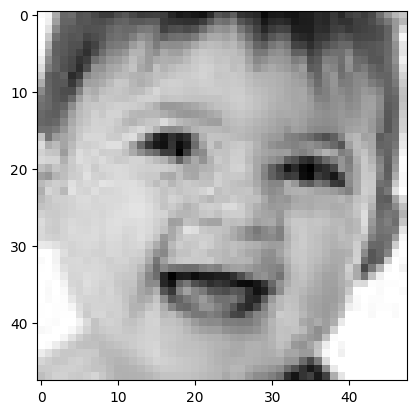

In [84]:
img = plt.imread('img/PrivateTest_32663.jpg')
plt.imshow(img, cmap='gray')
print(img.shape)
img = cvt_rgb48(img)
img = np.expand_dims(img, axis=0)
img.shape

In [85]:
CLASS = ['Angry','Disgust','Fear','Happy','Sad', 'Surprise', 'Neutral'] 

In [87]:
start = time.time()
pred = efficient.predict(img)
elapsed = time.time() - start

pred_label = CLASS[np.argmax(pred)]

print(f'=====Time Process =====')
print(f' EfficientNetB0 48x48')
print(f'=======================')
print(f' Time     : {elapsed: 0.5f} s')
print(f' Ekspresi : {pred_label}')

1/1 [==============================] - 0s 40ms/step
=====Time Process =====
 EfficientNetB0 48x48
 Time     :  0.07899 s
 Ekspresi : Happy


### Lr 0.0005

In [19]:
!nvidia-smi

Fri Dec  8 12:27:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:90:00.0 Off |                    0 |
| N/A   34C    P0    65W / 400W |  39002MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
model_name = 'EfficientNetB0_lr0005_20231119-225644'
efficient = load_model(f'models/{model_name}.h5')


(48, 48)


(1, 48, 48, 3)

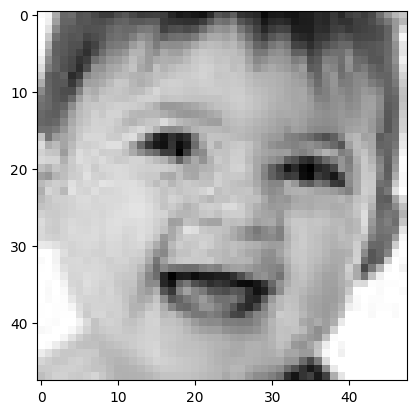

In [21]:
img = plt.imread('img/PrivateTest_32663.jpg')
plt.imshow(img, cmap='gray')
print(img.shape)
img = cvt_rgb48(img)
img = np.expand_dims(img, axis=0)
img.shape

In [22]:
CLASS = ['Angry','Disgust','Fear','Happy','Sad', 'Surprise', 'Neutral'] 

In [25]:
start = time.time()
pred = efficient.predict(img)
elapsed = time.time() - start

pred_label = CLASS[np.argmax(pred)]

print(f'=====Time Process =====')
print(f' EfficientNetB0 48x48')
print(f'=======================')
print(f' Time     : {elapsed: 0.5f} s')
print(f' Ekspresi : {pred_label}')

1/1 [==============================] - 0s 40ms/step
=====Time Process =====
 EfficientNetB0 48x48
 Time     :  0.08058 s
 Ekspresi : Happy


## EfficientNet 224x224

In [88]:
model_name = 'EfficientNetB0_lr001_224_20231128-081850'
efficient = load_model(f'models/{model_name}.h5')

(48, 48)


(1, 224, 224, 3)

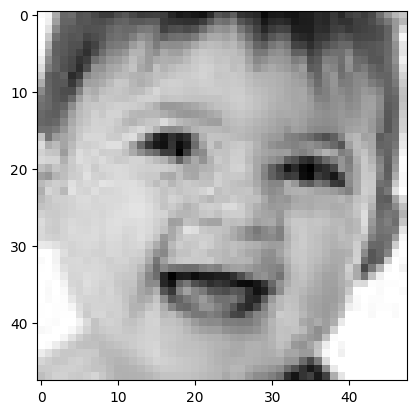

In [89]:
img = plt.imread('img/PrivateTest_32663.jpg')
plt.imshow(img, cmap='gray')
print(img.shape)
img = resized_gray(img, 224)
img = cvt_rgb48(img)
img = np.expand_dims(img, axis=0)
img.shape

In [91]:
start = time.time()
pred = efficient.predict(img)
elapsed = time.time() - start

pred_label = CLASS[np.argmax(pred)]

print()
print(f'=====Time Process =====')
print(f' EfficientNetB0 224x224')
print(f'=======================')
print(f' Time     : {elapsed: 0.5f} s')
print(f' Ekspresi : {pred_label}')

1/1 [==============================] - 0s 40ms/step

=====Time Process =====
 EfficientNetB0 224x224
 Time     :  0.08475 s
 Ekspresi : Happy


# EDA Hasil

## Lr 0.001

In [373]:
model_name = 'EfficientNetB0_lr001_20231119-172240'
efficient = load_model(f'models/{model_name}.h5')

In [374]:
model = efficient

In [456]:
data_flow = x_test

# Assuming you have a model named 'model'
# Modify the path and parameters based on your specific setup
predictions = model.predict(data_flow)

# Get the true labels from the generator
true_labels = np.argmax(y_test, axis=1)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Get indices for true positives, false negatives, and false positives
tp_indices = np.where((true_labels == predicted_labels) & (np.max(predictions, axis=1) > 0.5))[0]
fn_indices = np.where((true_labels != predicted_labels) & (np.max(predictions, axis=1) > 0.5))[0]
fp_indices = np.where((true_labels != predicted_labels) & (np.max(predictions, axis=1) <= 0.5))[0]

CLASS = ['Angry','Disgust','Fear','Happy','Sad', 'Surprise', 'Neutral'] 

# Function to plot images based on indices
def plot_images(indices, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)
    for i, index in enumerate(indices):  # Display the first 5 images
        plt.subplot(2, 5, i+1)
        img = data_flow[index]
        label = predicted_labels[index]
        plt.imshow(img)  # Assuming grayscale images
        plt.title(f'A : {CLASS[true_labels[index]]}, P : {CLASS[predicted_labels[index]]}')
        plt.axis('off')
    plt.show()




113/113 [==============================] - 1s 8ms/step


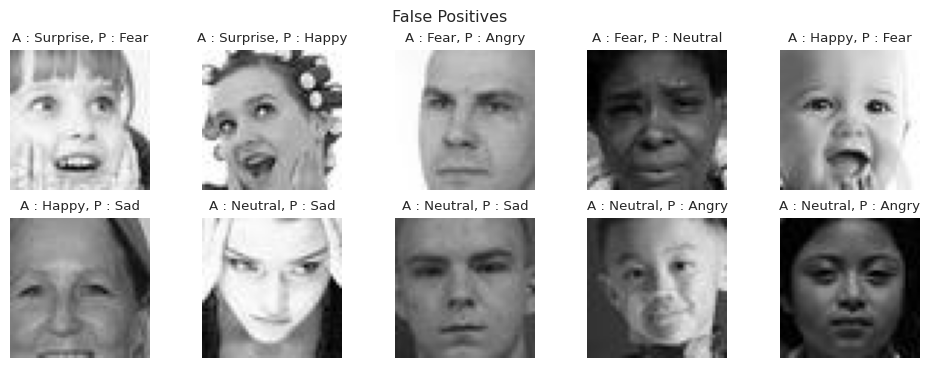

In [437]:
# # Plot False Positives
plot_images(fp_indices, 'False Positives')

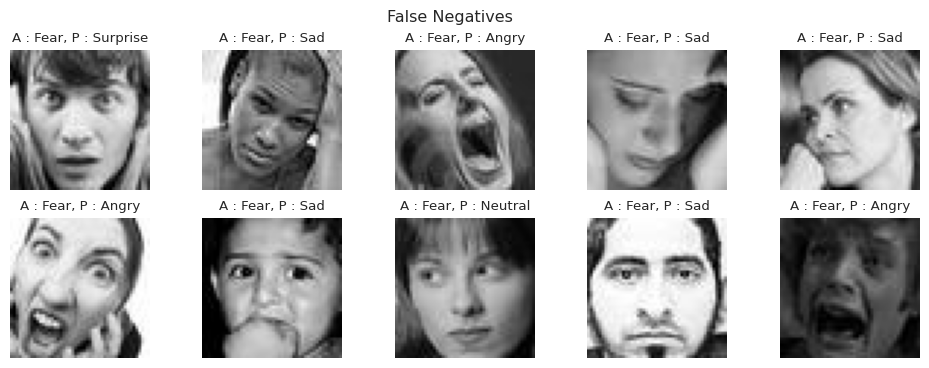

In [468]:
# # Plot False Negatives
plot_fn = fn_indices[90:100]
plot_images(plot_fn, 'False Negatives')

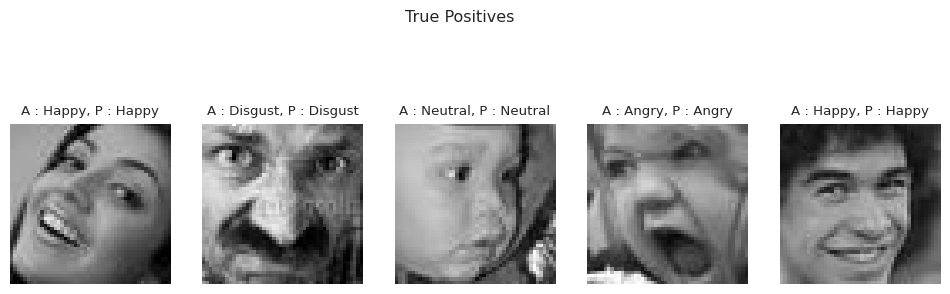

In [328]:
# Plot True Positives
plot_tp = np.random.choice(len(tp_indices), 10)

plot_images(plot_tp, 'True Positives')

## Lr 0.0005

In [473]:
model_name = 'EfficientNetB0_lr0005_20231119-225644'
efficient = load_model(f'models/{model_name}.h5')
model = efficient

In [474]:
data_flow = x_test

# Assuming you have a model named 'model'
# Modify the path and parameters based on your specific setup
predictions = model.predict(data_flow)

# Get the true labels from the generator
true_labels = np.argmax(y_test, axis=1)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Get indices for true positives, false negatives, and false positives
tp_indices = np.where((true_labels == predicted_labels) & (np.max(predictions, axis=1) > 0.5))[0]
fn_indices = np.where((true_labels != predicted_labels) & (np.max(predictions, axis=1) > 0.5))[0]
fp_indices = np.where((true_labels != predicted_labels) & (np.max(predictions, axis=1) <= 0.5))[0]

CLASS = ['Angry','Disgust','Fear','Happy','Sad', 'Surprise', 'Neutral'] 

# Function to plot images based on indices
def plot_images(indices, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)
    for i, index in enumerate(indices):  # Display the first 5 images
        plt.subplot(2, 5, i+1)
        img = data_flow[index]
        label = predicted_labels[index]
        plt.imshow(img)  # Assuming grayscale images
        plt.title(f'A : {CLASS[true_labels[index]]}, P : {CLASS[predicted_labels[index]]}')
        plt.axis('off')
    plt.show()




113/113 [==============================] - 2s 8ms/step


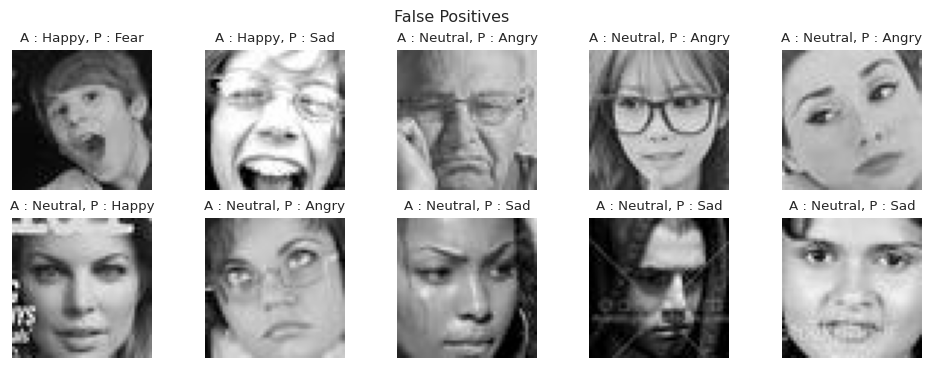

In [520]:
# # Plot False Positives
plot_images(fp_indices[10:20], 'False Positives')

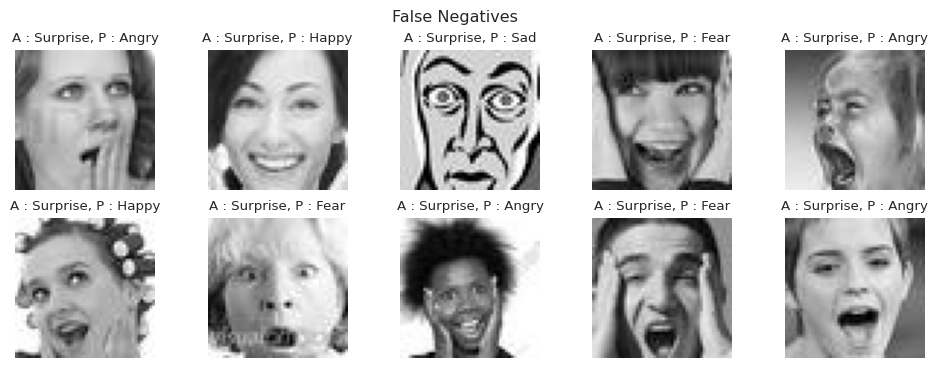

In [529]:
# # Plot False Negatives
plot_fn = fn_indices[10:20]
plot_images(plot_fn, 'False Negatives')

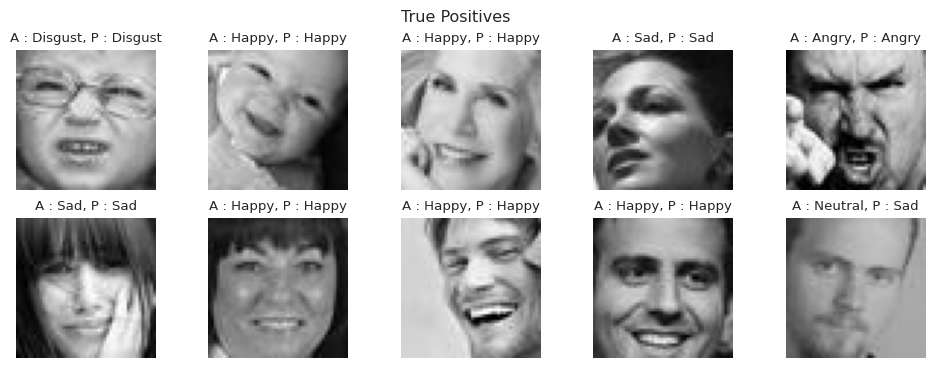

In [491]:
# Plot True Positives
plot_tp = np.random.choice(len(tp_indices), 10)

plot_images(plot_tp, 'True Positives')

# EDA VIDEO

In [61]:
model_name = 'EfficientNetB0_lr0005_20231119-225644'
efficient = load_model(f'models/{model_name}.h5')

In [65]:
pred = efficient.predict(x_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)

113/113 [==============================] - 1s 8ms/step


In [66]:
 # display confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(confusion_mtx)
print()

# # classification report
# class_names = ['Angry','Disgust','Fear','Happy','Sad', 'Surprise', 'Neutral']  
# print('Classification Report:')
# print(classification_report(y_true, y_pred, target_names=class_names, digits=digits))

Confusion Matrix:
[[435   3  16   4  20   5   8]
 [  1  52   1   0   1   0   0]
 [ 21   3 451   2  30  13   8]
 [ 10   0   6 840   4  12   7]
 [ 13   0  23  14 516   3  25]
 [  4   0  13   4   3 390   2]
 [ 17   2   8  11  18   6 564]]



In [71]:
confusion_mtx

array([[435,   3,  16,   4,  20,   5,   8],
       [  1,  52,   1,   0,   1,   0,   0],
       [ 21,   3, 451,   2,  30,  13,   8],
       [ 10,   0,   6, 840,   4,  12,   7],
       [ 13,   0,  23,  14, 516,   3,  25],
       [  4,   0,  13,   4,   3, 390,   2],
       [ 17,   2,   8,  11,  18,   6, 564]])

In [72]:
confusion = np.array([[0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0],
                      [8, 22, 2, 1933, 31, 0, 24],
                      [0, 0, 0, 1, 0, 0, 0],
                      [0, 0, 7, 0, 3, 10, 0],
                      [29, 57, 15, 169, 115, 0, 1170]
                      ])
confusion

array([[   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0],
       [   8,   22,    2, 1933,   31,    0,   24],
       [   0,    0,    0,    1,    0,    0,    0],
       [   0,    0,    7,    0,    3,   10,    0],
       [  29,   57,   15,  169,  115,    0, 1170]])

Text(48.25, 0.5, 'Actual')

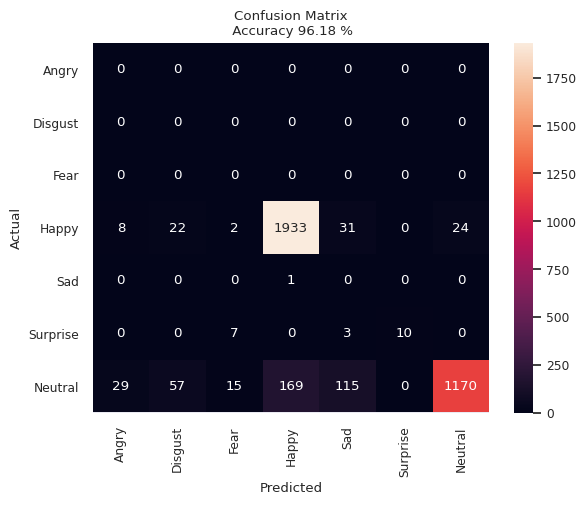

In [81]:
CLASS = ['Angry','Disgust','Fear','Happy','Sad', 'Surprise', 'Neutral'] 

cm = confusion

sns.set(font_scale=.8)
sns.heatmap(cm, annot=True, xticklabels=CLASS, yticklabels=CLASS, fmt='.0f')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.title(f'Confusion Matrix\n Accuracy 96.18 %')
plt.xlabel("Predicted") 
plt.ylabel("Actual") 

In [82]:
x_train

array([[[[247, 247, 247],
         [247, 247, 247],
         [213, 213, 213],
         ...,
         [ 96,  96,  96],
         [130, 130, 130],
         [147, 147, 147]],

        [[250, 250, 250],
         [247, 247, 247],
         [203, 203, 203],
         ...,
         [ 98,  98,  98],
         [131, 131, 131],
         [143, 143, 143]],

        [[246, 246, 246],
         [243, 243, 243],
         [192, 192, 192],
         ...,
         [ 79,  79,  79],
         [109, 109, 109],
         [133, 133, 133]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[254, 254, 254],
         [254, 254, 254],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[252, 252, 252],
         [253, 253, 253],
         [255, 255, 255],
         ...,
         [255, 255, 255],
        

In [74]:

# # classification report
class_names = ['Angry','Disgust','Fear','Happy','Sad', 'Surprise', 'Neutral']  
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

Classification Report:
              precision    recall  f1-score   support

       Angry     0.8683    0.8859    0.8770       491
     Disgust     0.8667    0.9455    0.9043        55
        Fear     0.8707    0.8542    0.8623       528
       Happy     0.9600    0.9556    0.9578       879
         Sad     0.8716    0.8687    0.8702       594
    Surprise     0.9091    0.9375    0.9231       416
     Neutral     0.9186    0.9010    0.9097       626

    accuracy                         0.9050      3589
   macro avg     0.8950    0.9069    0.9006      3589
weighted avg     0.9051    0.9050    0.9050      3589

